In [2]:
import numpy as np
import matplotlib.pyplot as plt
from webbpsf import NIRCam
from astropy.io import fits
from jwst.resample import resample_step
from jwst.datamodels import ImageModel
import os
os.environ['WEBBPSF_PATH'] = '/quasar/yichenliu/webbpsf-data'

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
from webbpsf import NIRCam
from jwst.datamodels import ImageModel
from astropy.wcs import WCS

# Initialize NIRCam with F250M filter
nircam = NIRCam()
nircam.filter = 'F250M'

from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['image.interpolation'] = 'none'

np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

import os, sys

from importlib import reload

import numpy as np
import numpy.linalg as la
from numpy import fft

import matplotlib as mpl
import matplotlib.pyplot as plt

import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.table import Table
from astropy.visualization import AsinhStretch
from astropy.wcs import WCS
from astropy.nddata import Cutout2D
from astropy.visualization import astropy_mpl_style
from astropy.stats import sigma_clipped_stats
from astropy.nddata import NDData

from photutils.detection import DAOStarFinder
from photutils.psf import EPSFBuilder
from photutils.psf import extract_stars
from photutils.centroids import centroid_com

from scipy.ndimage import shift

stretch = AsinhStretch()

plt.style.use(astropy_mpl_style)
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['image.interpolation'] = 'nearest'

np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

%matplotlib inline
%config InlineBackend.figure_format='retina'

sys.path.append('..')

import dither.utils as dutils
import dither.wrapper as wrapper
import dither.updated as updated

**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-065 DOESN'T MATCH THE CURRENT ONLINE VERSION PRDOPSSOC-067
Please consider updating pysiaf, e.g. pip install --upgrade pysiaf or conda update pysiaf


In [3]:
%matplotlib inline

In [4]:
# Function to extract the central 10% of an array
def extract_central_region(image, fraction=0.2):
    center_x, center_y = np.array(image.shape) // 2
    half_width_x, half_width_y = (np.array(image.shape) * fraction // 2).astype(int)
    return image[
        center_x - half_width_x : center_x + half_width_x,
        center_y - half_width_y : center_y + half_width_y,
    ]

make oversampled image

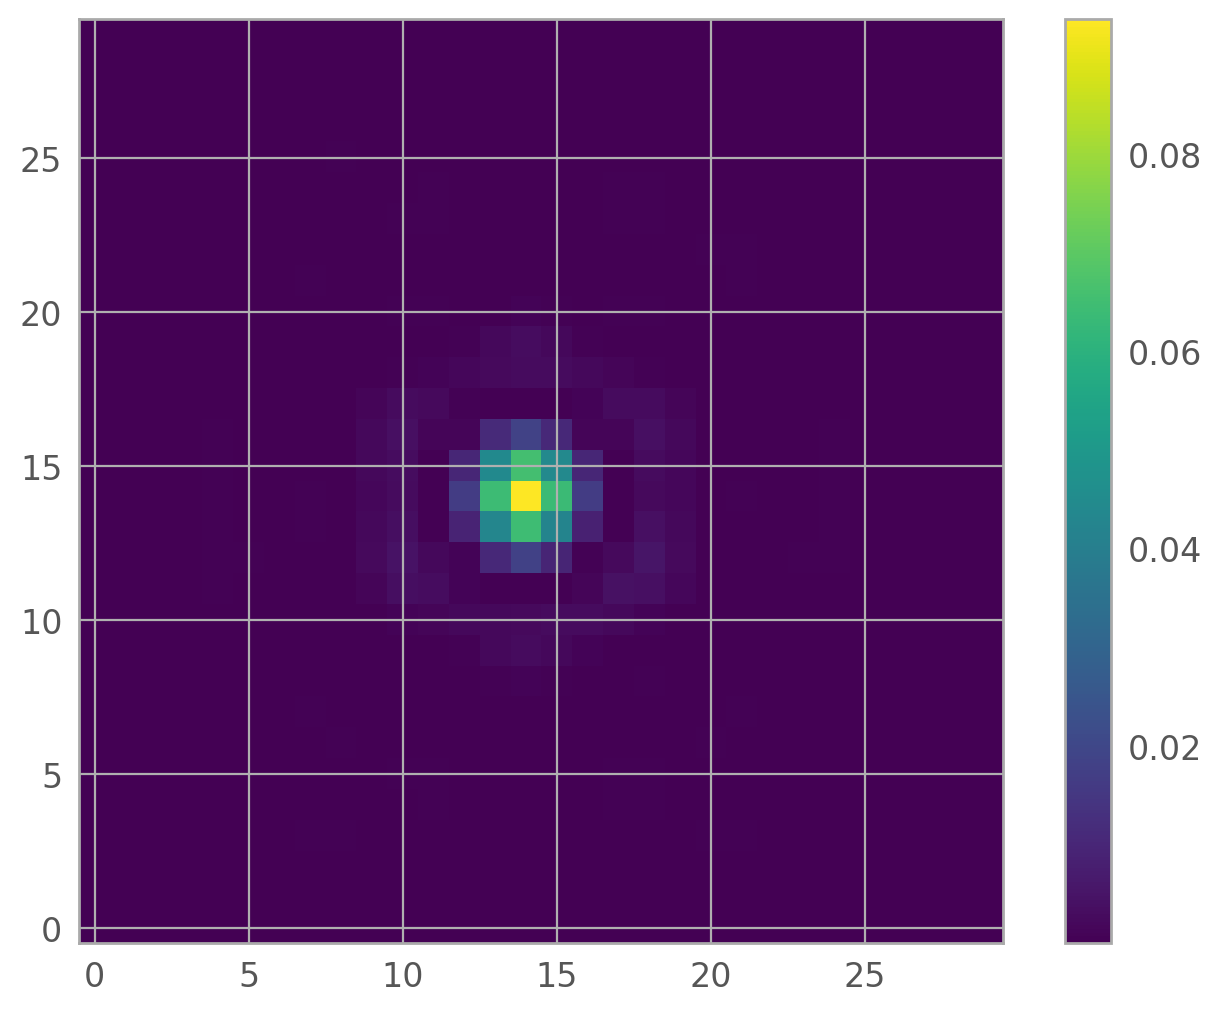

In [5]:
# Generate oversampled PSF (factor of 2)
oversample_factor = 2
app = 0.062 # pixel scale in arcsec / pixel for SW channel
nircam.options['source_offset_x'] = -0.25*app
nircam.options['source_offset_y'] = -0.25*app
oversampled_psf = nircam.calc_psf(oversample=oversample_factor)
oversampled_data = oversampled_psf[0].data

plt.imshow(extract_central_region(oversampled_data), cmap='viridis')
plt.colorbar()

make 9 dither images

In [56]:
# Generate 9 dithered images at random positions
num_dithers = 9
dither_images = []
# dither_offsets_pixel = np.random.uniform(-0.5, 0.5, size=(num_dithers, 2))  # random offsets in pixel
dither_offsets_pixel = np.random.rand(num_dithers, 2) - 0.5  # random offsets in pixel
dither_offsets_pixel[0] = [0, 0]
dither_offsets = dither_offsets_pixel*app # random offsets in arcsec

for i, (dx, dy) in enumerate(dither_offsets):
    # Set the image shift for dithering
    # nircam.options['image_shift'] = (dx, dy)
    nircam.options['source_offset_x'] = dx
    nircam.options['source_offset_y'] = dy
    # print(nircam.options['source_offset_x'], nircam.options['source_offset_y'])
    psfdu = nircam.calc_psf(oversample=1)
    # save data
    psf = psfdu[0].data
    psf += np.random.normal(loc=0, scale=0.39/5, size=psf.shape) # roughly 5 sigma noise
    dither_images.append(psf)
    # output_file = f'dither_image/{i}.fits'
    # image_model = ImageModel(psfdu)
    # # wcs = WCS(psfdu[0].header)
    # # test_wcs.bounding_box = None
    # # image_model.meta.wcs = test_wcs
    # image_model.save(output_file)
    # # psfdu.writeto(output_file, overwrite=True)  # Set overwrite=True to overwrite existing files

# print(f'HDUList saved to {output_file}')

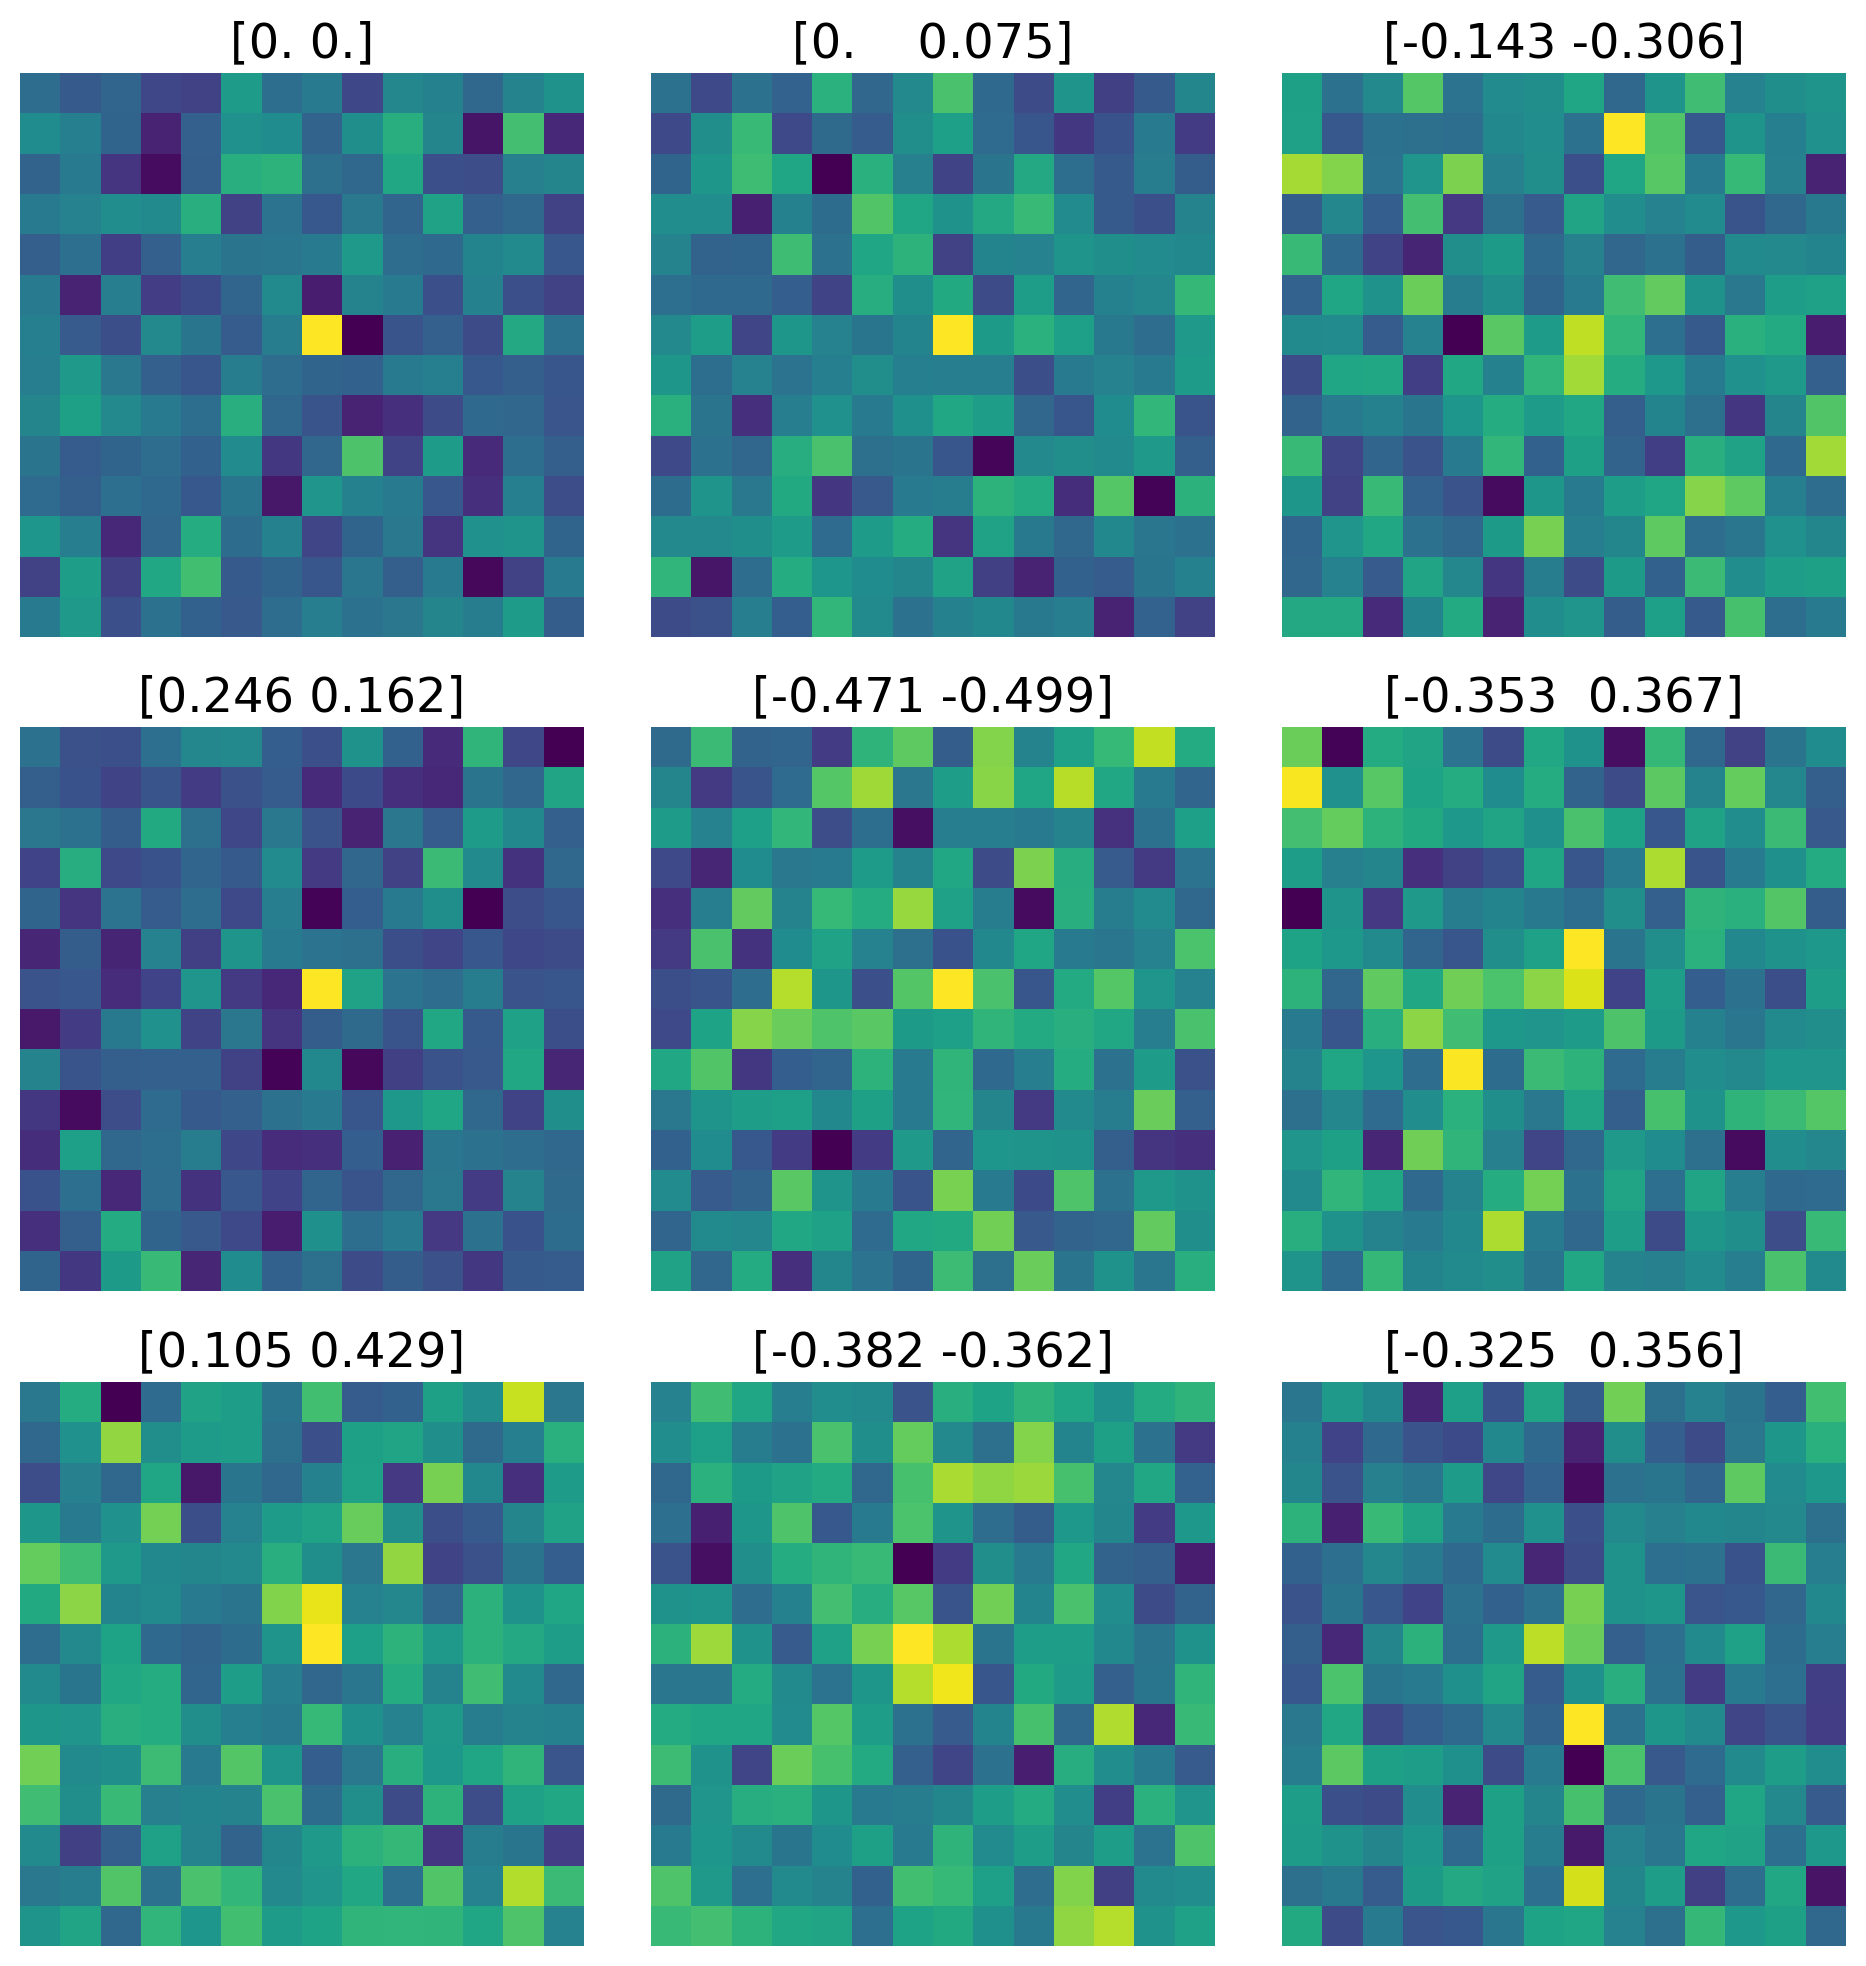

In [57]:
central_dithers = [extract_central_region(image) for image in dither_images]

# Plot the central part of 9 dithered images in a grid
fig, axs = plt.subplots(3, 3, figsize=(10, 10))

for i, ax in enumerate(axs.flat):
    ax.imshow(central_dithers[i], origin='lower', cmap='viridis')
    ax.set_title(dither_offsets_pixel[i])
    ax.axis('off')  # Hide axes for cleaner visualization

plt.tight_layout()
plt.show()

naive drizzle

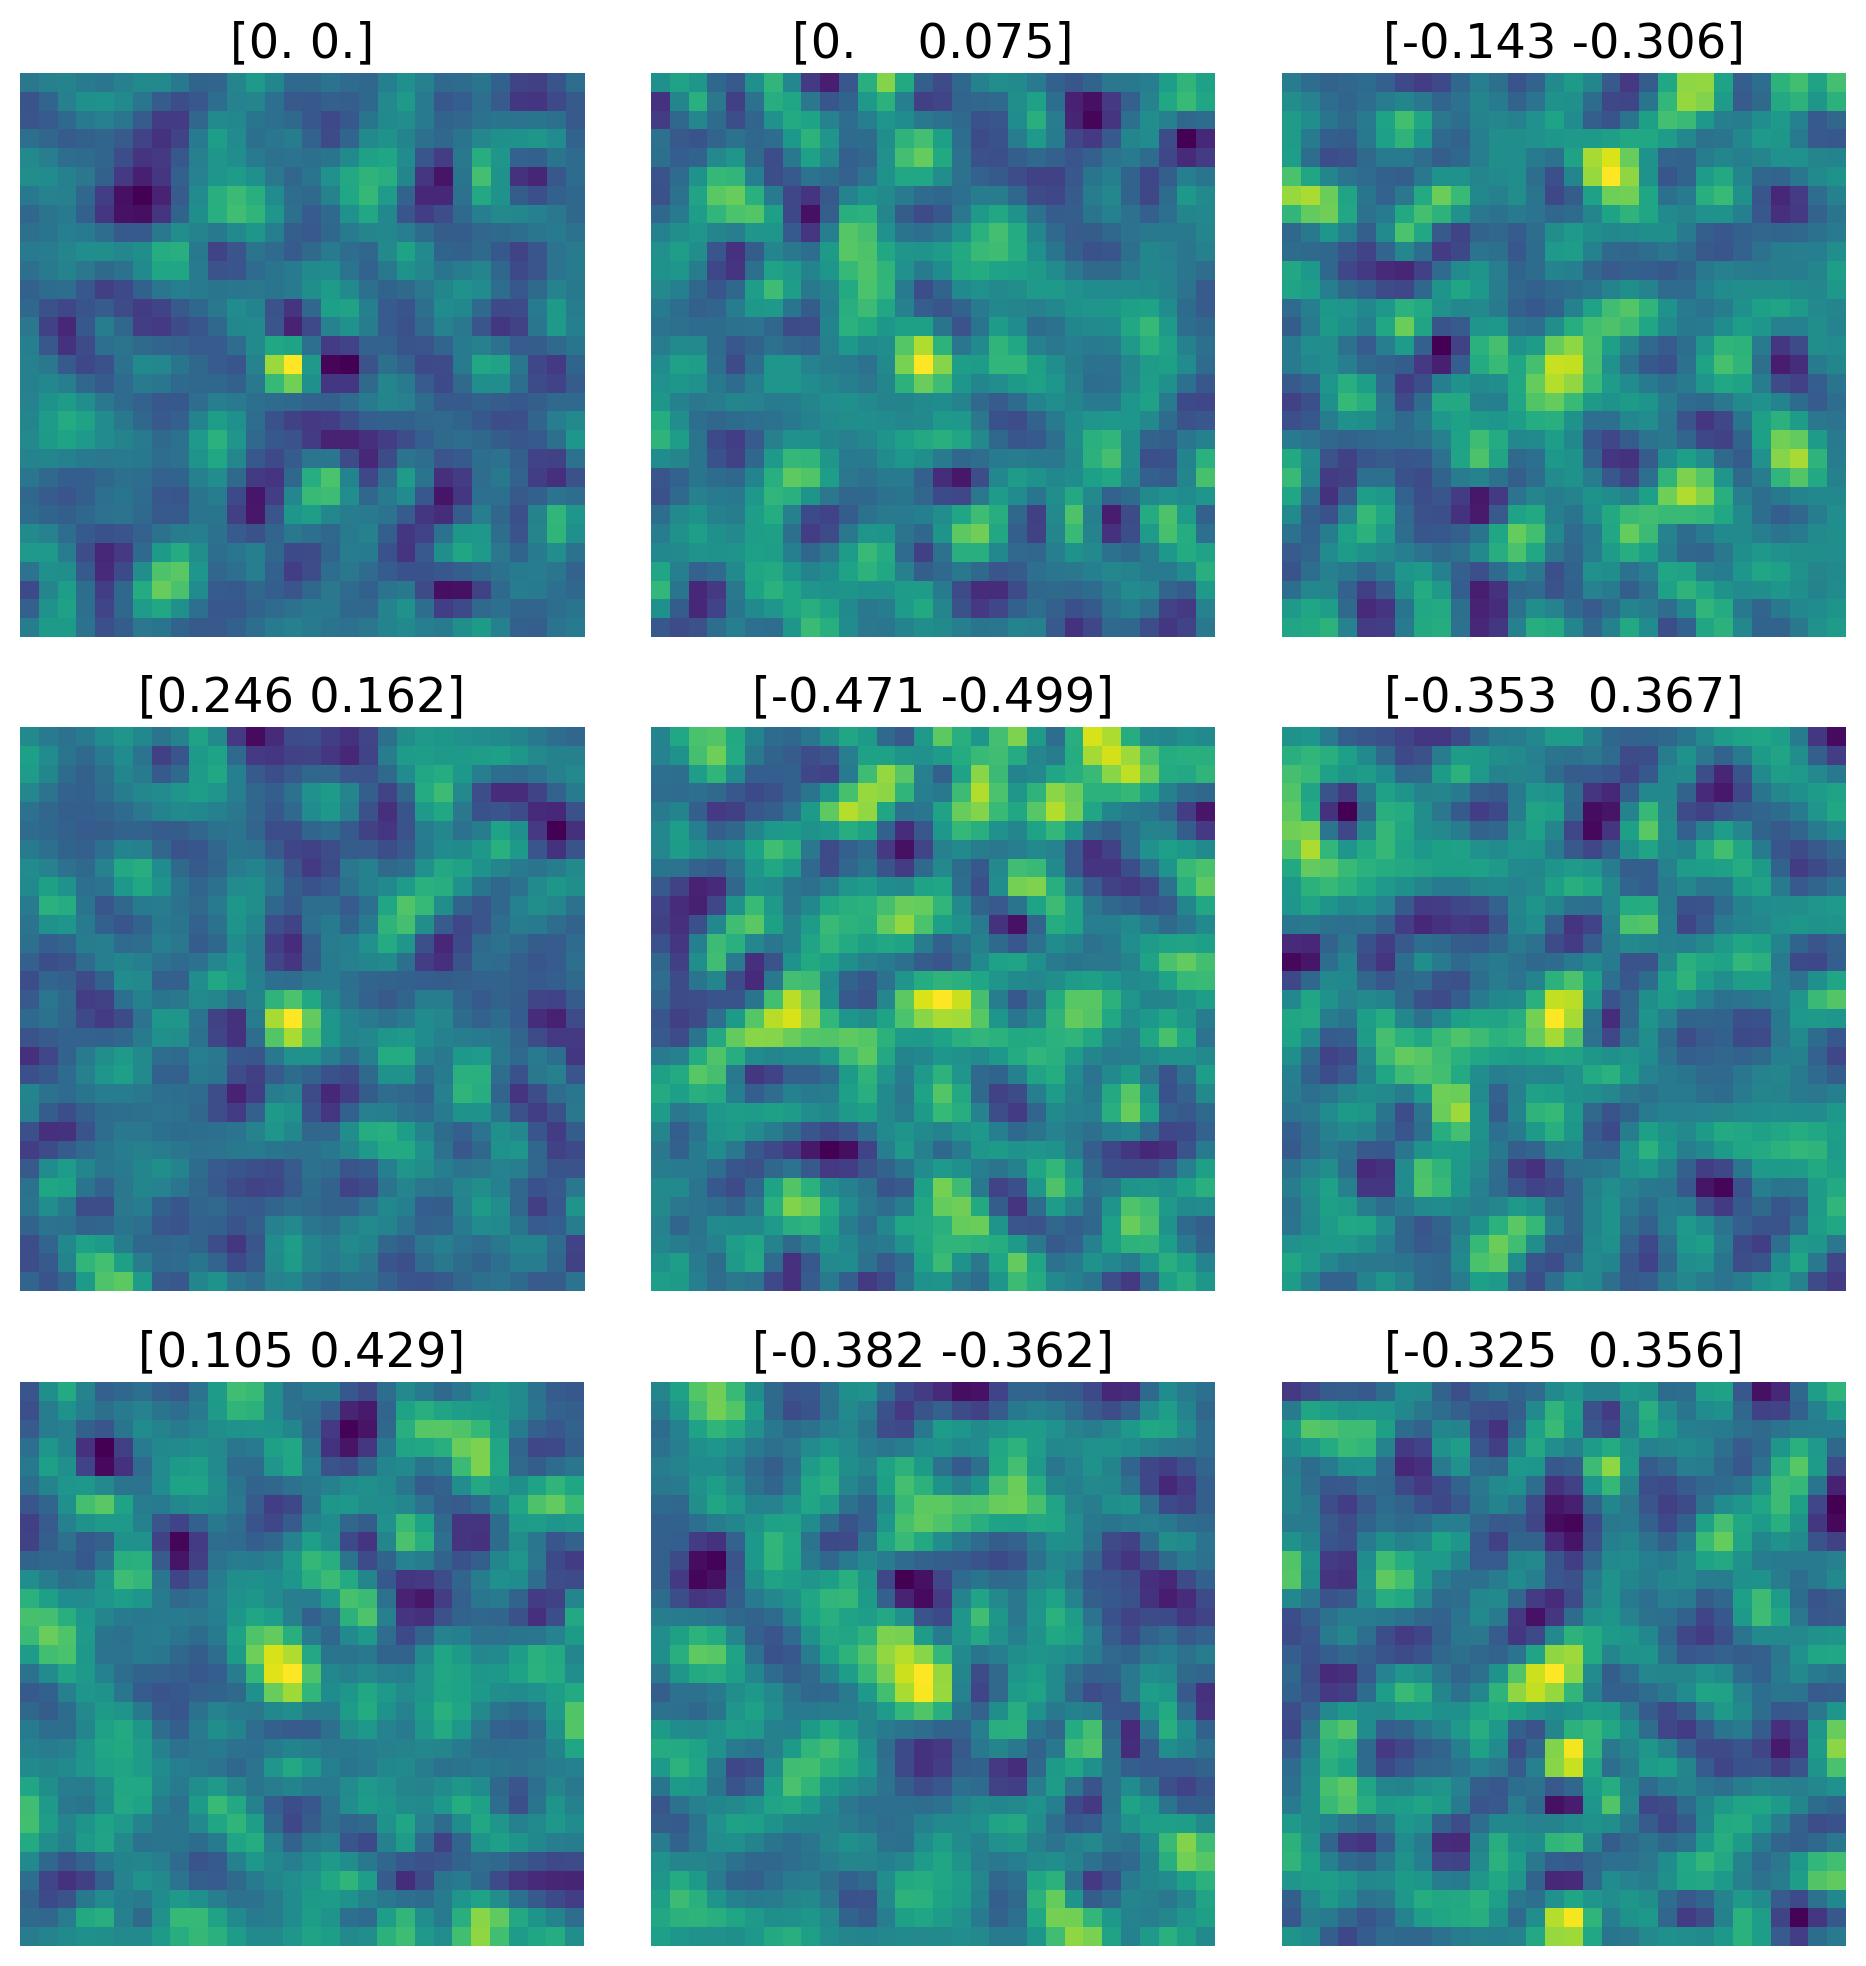

In [58]:
from scipy.ndimage import shift, zoom

shifted_images = []
for image, (dx, dy) in zip(dither_images, dither_offsets_pixel):
    # shifted_image = enlarge_and_reproject(image, dx, dy)
    shifted_image = image.copy()
    shifted_image = zoom(shifted_image, zoom=2)/4
    shifted_image = shift(shifted_image, shift=[-dy*2-0.5, -dx*2-0.5], order=3)
    shifted_images.append(shifted_image)



central_dithers = [extract_central_region(image) for image in shifted_images]

# Plot the central part of 9 dithered images in a grid
fig, axs = plt.subplots(3, 3, figsize=(10, 10))

for i, ax in enumerate(axs.flat):
    ax.imshow(central_dithers[i], origin='lower', cmap='viridis')
    ax.set_title(dither_offsets_pixel[i])
    ax.axis('off')  # Hide axes for cleaner visualization

plt.tight_layout()
plt.show()

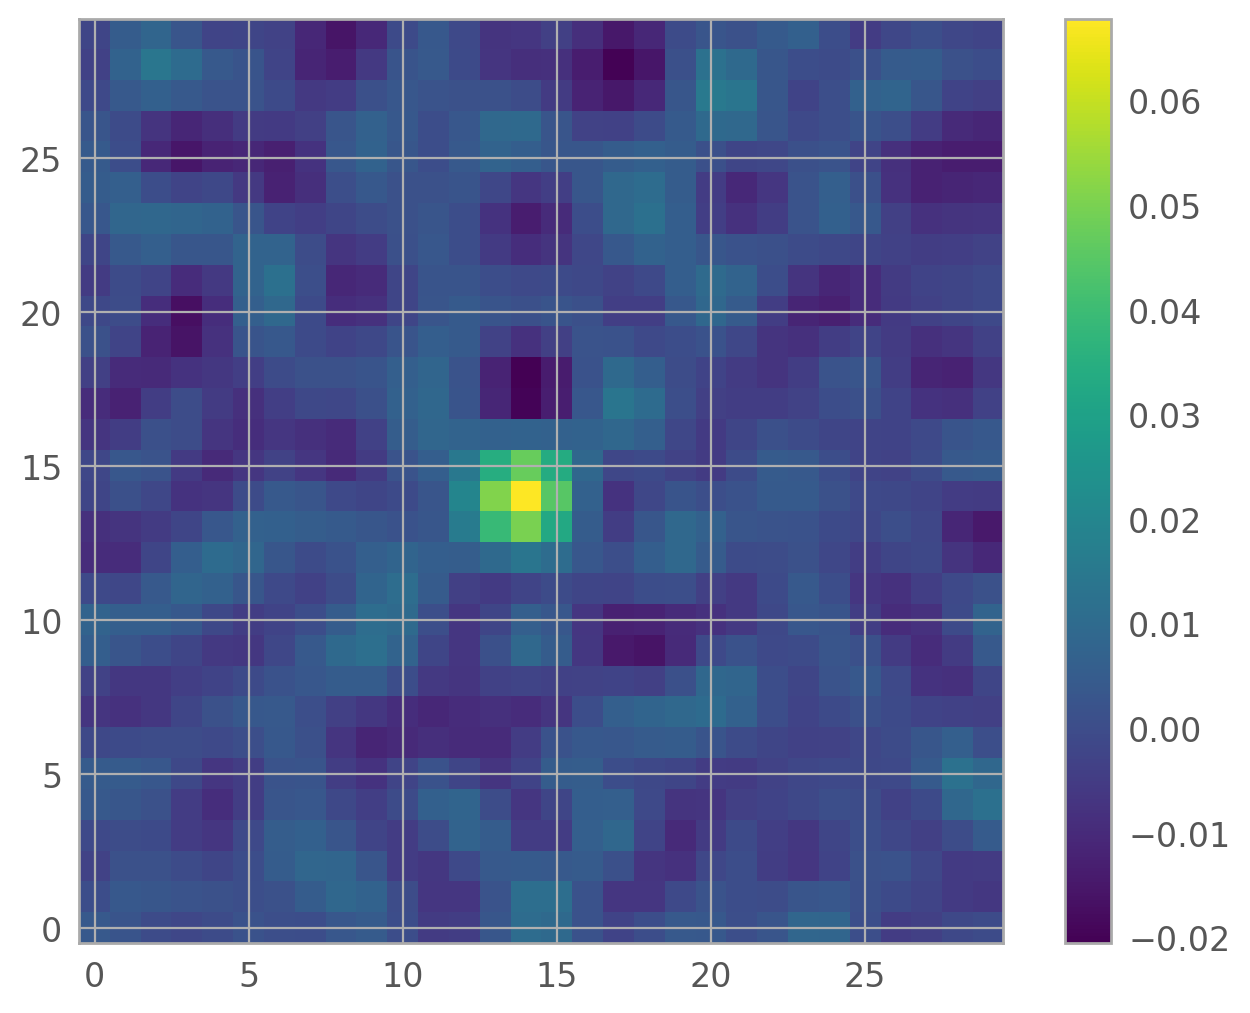

In [59]:
drizzled_image = np.sum(shifted_images, axis=0)/9

plt.imshow(extract_central_region(drizzled_image), cmap='viridis')
plt.colorbar()

test residual

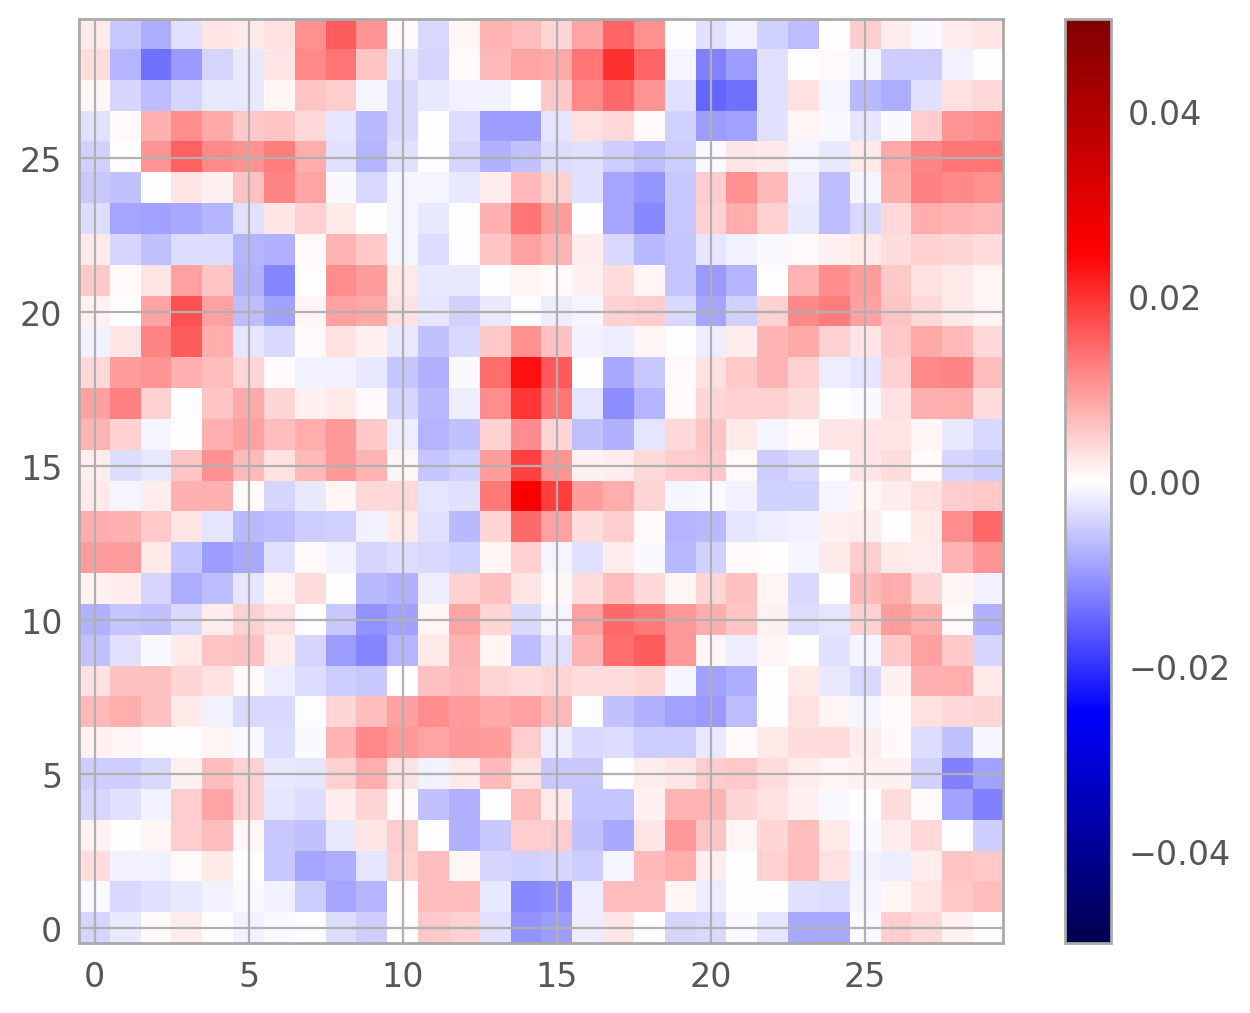

In [71]:
plt.imshow(extract_central_region(oversampled_data - drizzled_image),
           cmap='seismic', vmin=-0.05, vmax=0.05)
plt.colorbar()

using Lauer(99) method

In [61]:
aligned_atlas = dither_images
centroids = dither_offsets_pixel
cx = 39
cy = 39

# NOTE: dutils.get_pixel_center_from_array returns 40, needs to be fix?

centroids

array([[ 0.   ,  0.   ],
       [ 0.   ,  0.075],
       [-0.143, -0.306],
       [ 0.246,  0.162],
       [-0.471, -0.499],
       [-0.353,  0.367],
       [ 0.105,  0.429],
       [-0.382, -0.362],
       [-0.325,  0.356]])

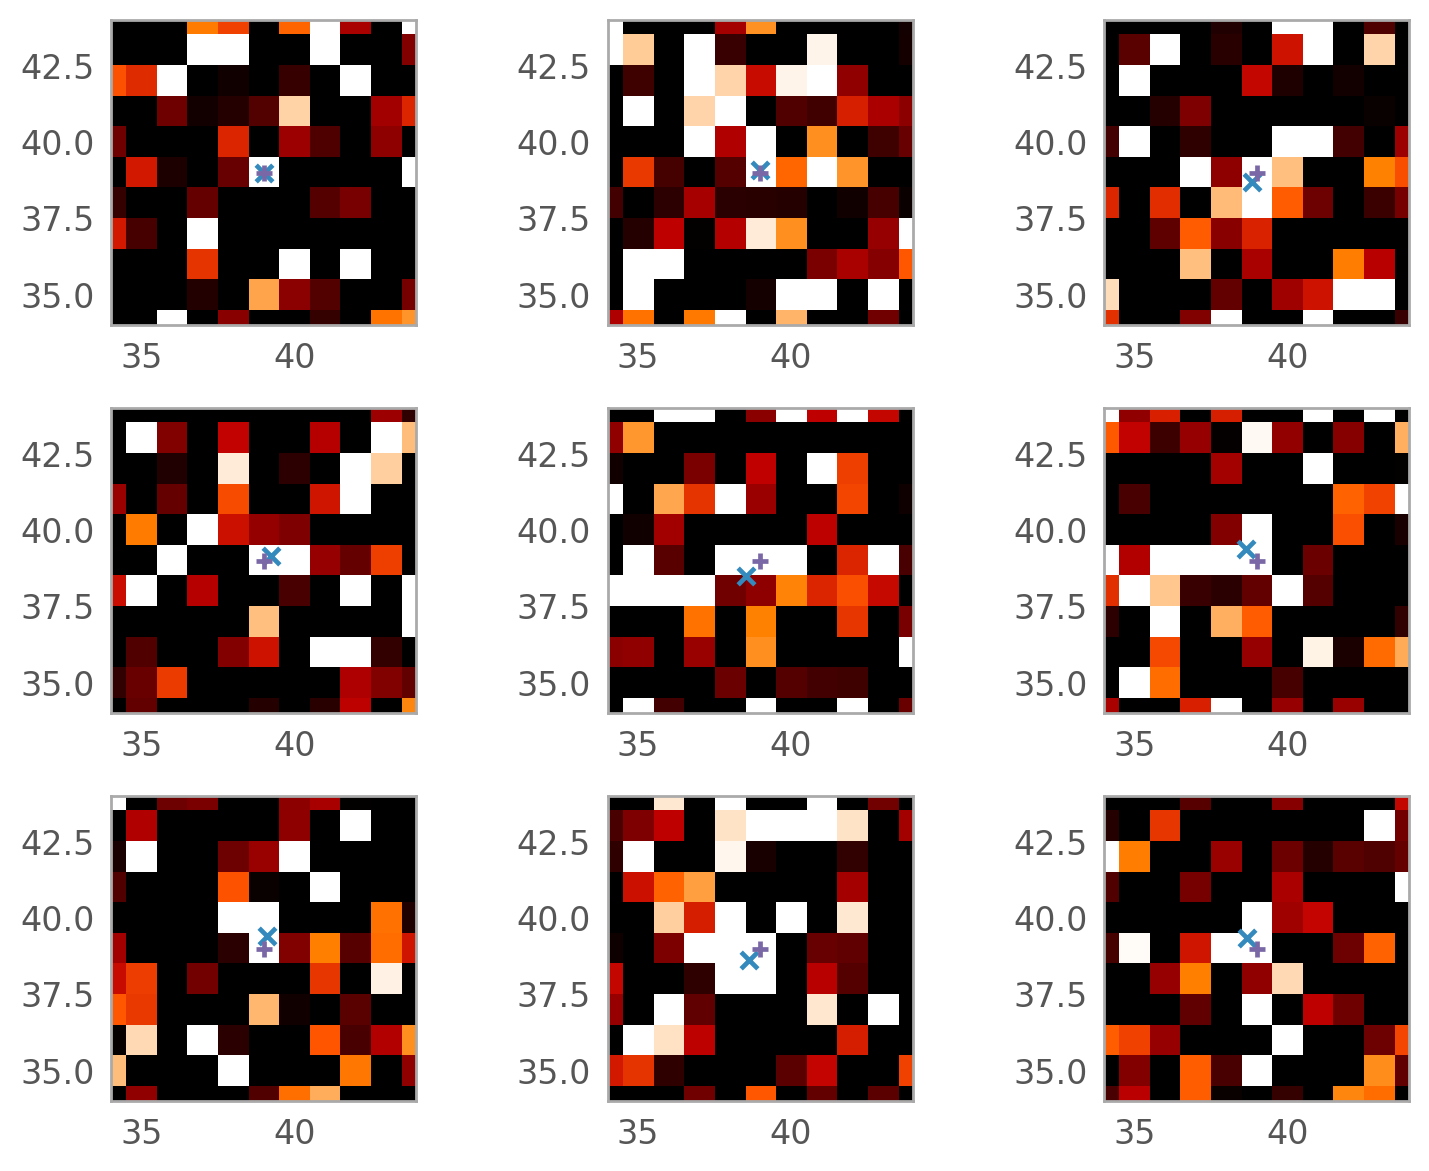

In [62]:
fig, axs = plt.subplots(3, 3)
axs = axs.flat
for i in range(9): 
    data = aligned_atlas[i]
    qso_center = [cx+centroids[i, 0], cx+centroids[i, 1]]
    img_center = [cx, cy]
    axs[i].imshow(np.arcsinh(data), vmin=0, vmax=0.1)
    axs[i].scatter(*qso_center, marker='x')
    axs[i].scatter(*img_center, marker='+')
    axs[i].set_xlim(cx-5, cx+5)
    axs[i].set_ylim(cy-5, cy+5)
    axs[i].grid(False)
plt.tight_layout()
plt.show()

[[ 0.     0.     1.   ]
 [ 0.075  0.     1.   ]
 [-0.306 -0.143  1.   ]
 [ 0.162  0.246  1.   ]
 [-0.499 -0.471  1.   ]
 [ 0.367 -0.353  1.   ]
 [ 0.429  0.105  1.   ]
 [-0.362 -0.382  1.   ]
 [ 0.356 -0.325  1.   ]]


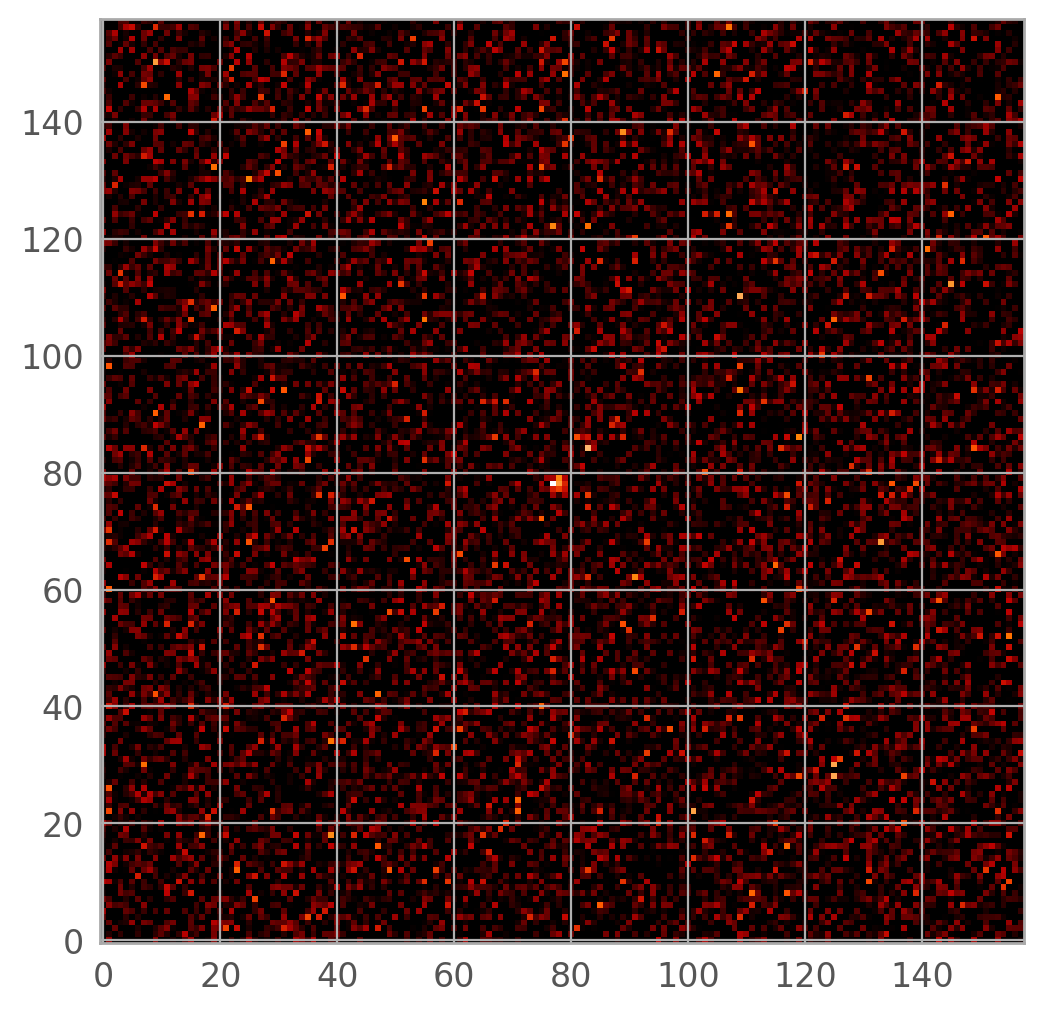

In [70]:
from dither.wrapper import NR_FREQ, NC_FREQ
NSUB = 2


used_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8]

# [y, x, wt]
offsets = np.hstack((centroids[used_indices, 1:2], 
                     centroids[used_indices, 0:1], 
                     [[1]]*len(used_indices)))
# offsets[0, 0] = 0
# offsets[0, 1] = 0
print(offsets)

Atotal = np.zeros((NC_FREQ, NR_FREQ))
for i, j in enumerate(used_indices): 
    data = aligned_atlas[j]
    nx, ny = data.shape
    data_large = np.zeros((NC_FREQ, NR_FREQ))
    data_large[:nx*NSUB:NSUB, :ny*NSUB:NSUB] = data
    A = updated.real2dfft_forward(data_large)
    n = i + 1
    Aphased = updated.phase_shift(A, offsets, n, verbose=False)
    Atotal += Aphased

f = updated.real2dfft_backward(Atotal)

nx, ny = aligned_atlas[0].shape
nx_large = nx*NSUB
ny_large = ny*NSUB
plt.imshow(stretch(f[:nx_large, :ny_large]))
plt.show()

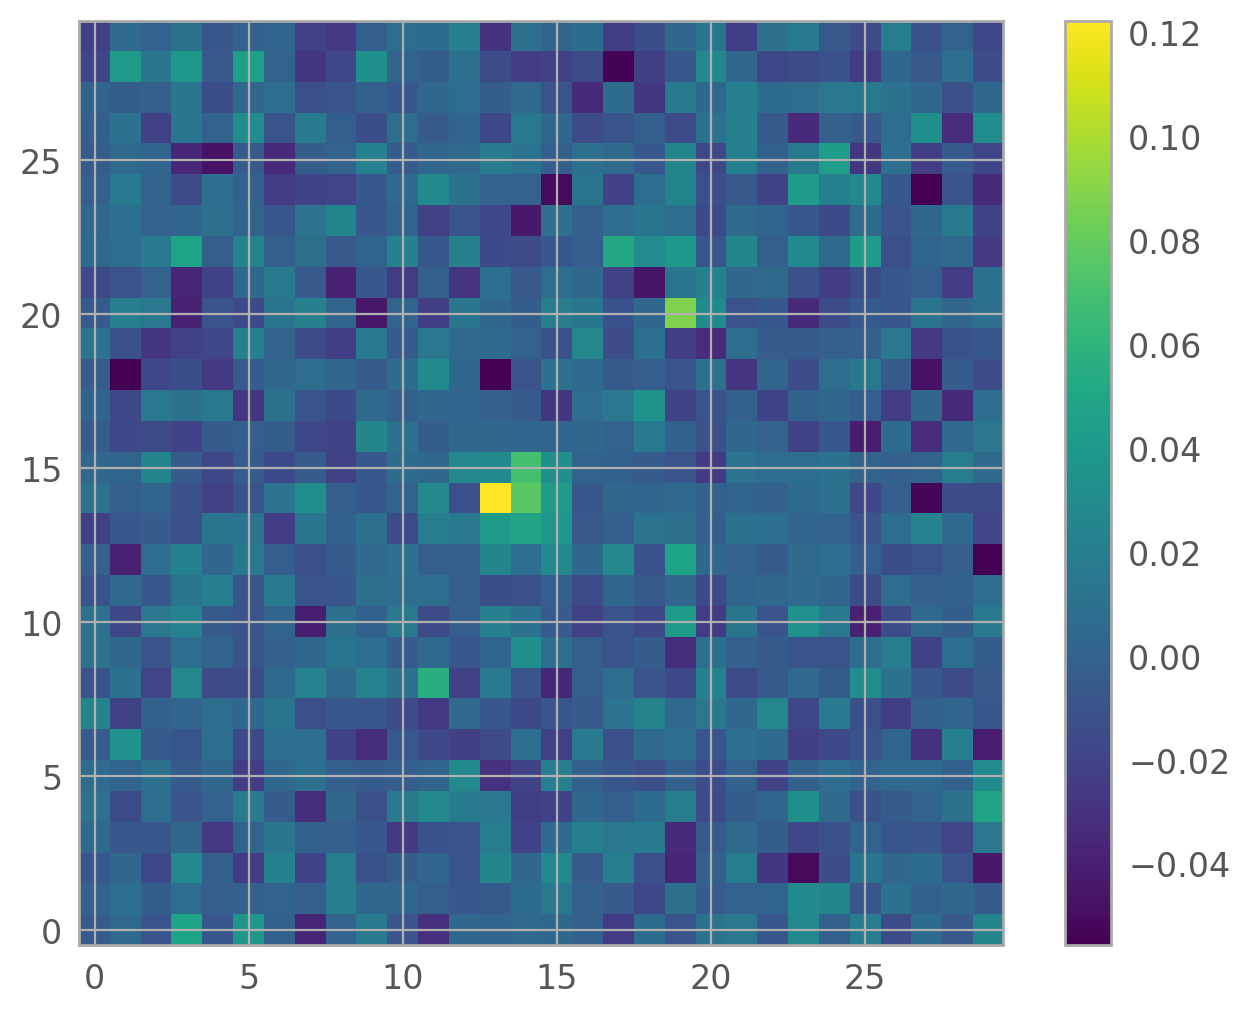

In [64]:
proper_coadd_image = f[:nx_large, :ny_large]/4

# plt.imshow(proper_coadd_image, cmap='viridis', vmax=0.05)
# plt.colorbar()

# qso_center = [cx*2+centroids[0, 0]*2, cx*2+centroids[0, 1]*2]
# img_center = [cx*2, cy*2]
# plt.scatter(*qso_center, marker='x')
# plt.scatter(*img_center, marker='+')
# plt.xlim(70, 90)
# plt.ylim(70, 90)

plt.imshow(extract_central_region(proper_coadd_image), cmap='viridis')
plt.colorbar()

test residual

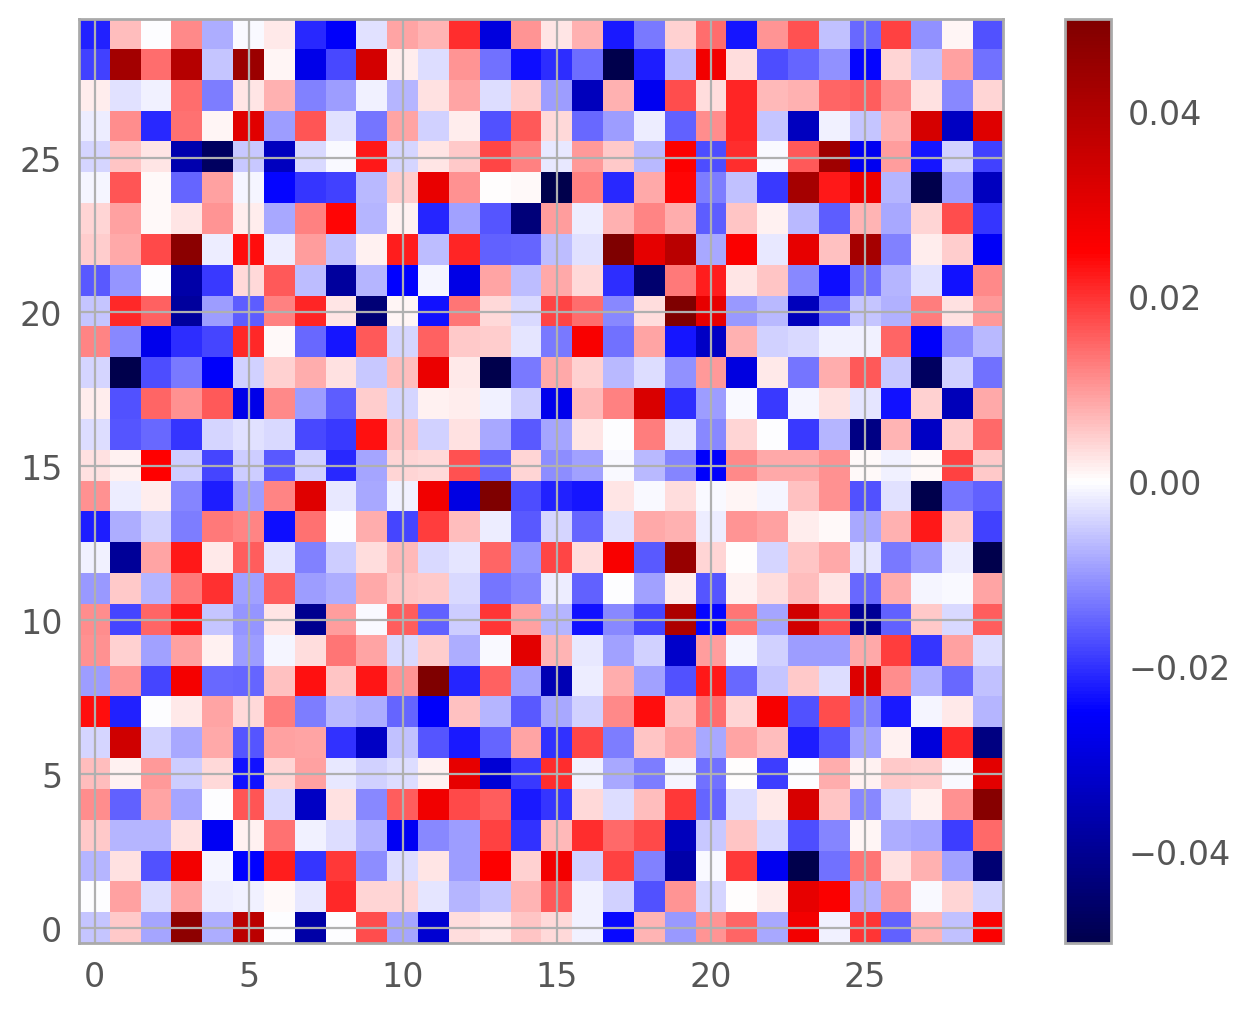

In [69]:
# proper_coadd_image_shifted = proper_coadd_image

plt.imshow(extract_central_region(proper_coadd_image - oversampled_data), 
           cmap='seismic', vmin=-0.05, vmax=0.05)
plt.colorbar()

compare power spectrum

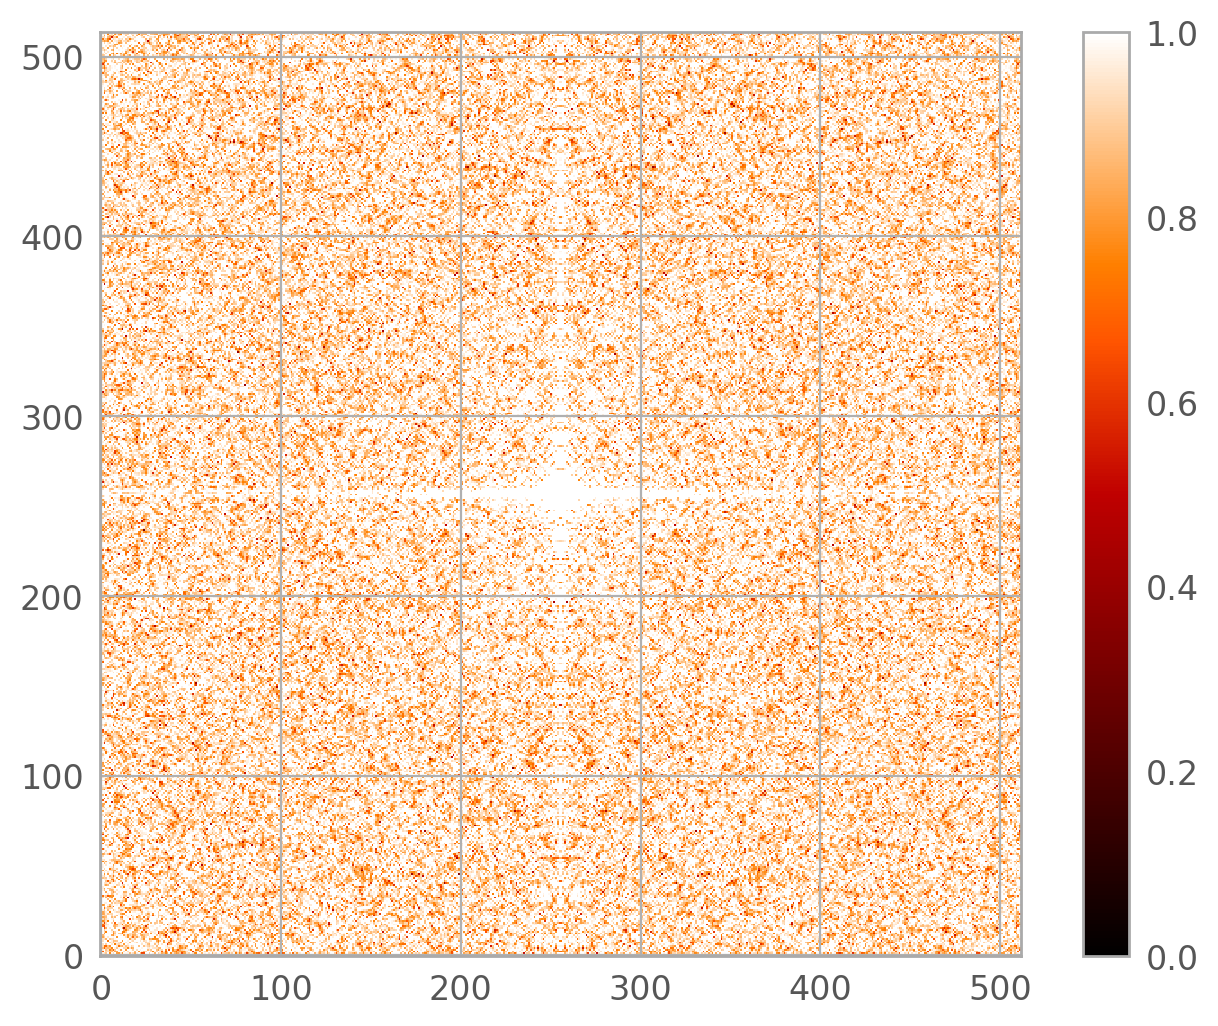

In [33]:
pow = dutils.get_power_spectrum_from_realfft2d(wrapper.fft(proper_coadd_image))
plt.imshow(pow**0.1, vmin=0, vmax=1)
plt.colorbar()
plt.show()

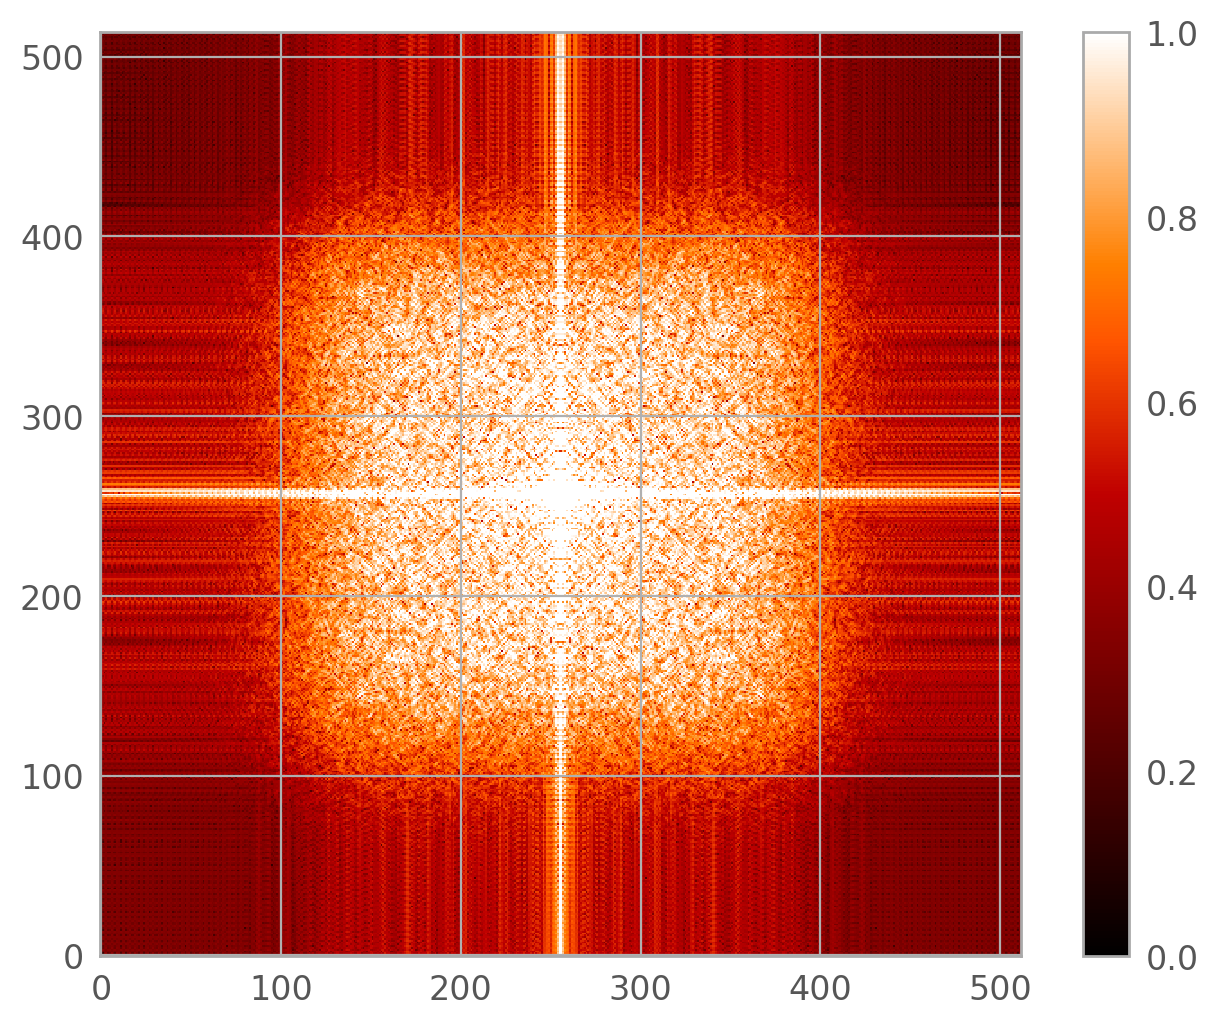

In [34]:
pow = dutils.get_power_spectrum_from_realfft2d(wrapper.fft(drizzled_image))
plt.imshow(pow**0.1, vmin=0, vmax=1)
plt.colorbar()
plt.show()

In [259]:
pow

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [45]:
with fits.open('/quasar/yichenliu/cutout_f250m/jw01764001001_02101_00001_nrcblong_cal_bsub_aligned_cutout.fits') as hdu: 
    print(hdu.info())
    test_wcs = WCS(hdu[1].header)
    data = hdu[1].data

Filename: /quasar/yichenliu/cutout_f250m/jw01764001001_02101_00001_nrcblong_cal_bsub_aligned_cutout.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     361   ()      
  1  SCI           1 ImageHDU       130   (158, 158)   float32   
  2  ERR           1 ImageHDU        41   (158, 158)   float32   
  3  DQ            1 ImageHDU        42   (158, 158)   int32 (rescales to uint32)   
  4  AREA          1 ImageHDU        40   (158, 158)   float32   
  5  VAR_POISSON    1 ImageHDU        40   (158, 158)   float32   
  6  VAR_RNOISE    1 ImageHDU        40   (158, 158)   float32   
  7  VAR_FLAT      1 ImageHDU        40   (158, 158)   float32   


2024-11-18 13:22:45,921 - stpipe - INFO - 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                
20

None
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]


In [81]:
from gwcs import wcs
from astropy.modeling.models import Shift, Pix2Sky_TAN, RotateNative2Celestial
from gwcs.coordinate_frames import CelestialFrame

# Define parameters
ra_ref = 10.0  # Reference RA in degrees
dec_ref = 20.0  # Reference Dec in degrees
pixel_scale = 0.1 / 3600  # Pixel scale in degrees/pixel

# Define transformations
shift_x = Shift(-1024)
shift_y = Shift(-1024)
scale = Pix2Sky_TAN()
rotation = RotateNative2Celestial(ra_ref, dec_ref, 180)  # Rotate to celestial

# Define output coordinate frame
celestial_frame = CelestialFrame(reference_frame='ICRS', name='world')

# Combine transformations into a pipeline
forward_transform = (shift_x & shift_y) | scale | rotation

# Create the WCS object
# gwcs_wcs = wcs.WCS(forward_transform=forward_transform, output_frame=celestial_frame)
# gwcs_wcs = wcs.WCS(forward_transform=forward_transform, output_frame='world')
gwcs_wcs = wcs.WCS(forward_transform=forward_transform, output_frame='world')

# Define bounding box
gwcs_wcs.bounding_box = None


In [72]:
from jwst.datamodels import ImageModel

# Load the image model
model = ImageModel('0.fits')

# Attach the gwcs object
model.meta.wcs = gwcs_wcs

# Save the updated model
model.save('image1_with_gwcs.fits')

2024-11-18 11:44:35,302 - stpipe - WARNING - /quasar/yichenliu/anaconda3/envs/py312/lib/python3.12/site-packages/stdatamodels/validate.py:38: ValidationWarning: While validating meta.instrument.name the following error occurred:
'NIRCam' is not one of ['NIRCAM', 'NIRSPEC', 'MIRI', 'TFI', 'FGS', 'NIRISS', 'ANY', 'N/A']

Failed validating 'enum' in schema:
    OrderedDict([('title', 'Instrument used to acquire the data'),
                 ('type', 'string'),
                 ('enum',
                  ['NIRCAM',
                   'NIRSPEC',
                   'MIRI',
                   'TFI',
                   'FGS',
                   'NIRISS',
                   'ANY',
                   'N/A']),
                 ('fits_keyword', 'INSTRUME'),
                 ('blend_table', True)])

On instance:
    'NIRCam'
  warnings.warn(errmsg, ValidationWarning)



2024-11-18 11:44:35,304 - stpipe - WARNING - /quasar/yichenliu/anaconda3/envs/py312/lib/python3.12/site-packages/stdatamodels/validate.py:38: ValidationWarning: While validating meta.instrument.channel the following error occurred:
'Long' is not valid under any of the given schemas

Failed validating 'anyOf' in schema:
    OrderedDict([('title', 'Instrument channel'),
                 ('type', 'string'),
                 ('anyOf',
                  [{'enum': ['1',
                             '2',
                             '3',
                             '4',
                             '12',
                             '34',
                             '123',
                             '234',
                             '1234']},
                   {'enum': ['LONG', 'SHORT']},
                   {'enum': ['ANY', 'N/A']}]),
                 ('fits_keyword', 'CHANNEL'),
                 ('blend_table', True)])

On instance:
    'Long'
  warnings.warn(errmsg, ValidationWarning

'image1_with_gwcs.fits'

In [107]:
from jwst.resample.resample import ResampleData
from jwst.datamodels import ModelContainer, ModelLibrary

dither_image_dir = 'dither_image'
# Load the 9 input models (as a ModelContainer or list of data models)
# input_files = [os.path.join(dither_image_dir, filename) 
#                for filename in os.listdir(dither_image_dir)]
# input_files = ['image1_with_gwcs.fits']
imput_files = cutout_paths
input_models = ModelLibrary(input_files)

# Initialize ResampleData with desired settings
resampler = ResampleData(
    input_models=input_models,
    # output='drizzled_output.fits',
    # single=False,  # Combine all inputs into one output
    # # single=True,  # Combine all inputs into one output
    # pixfrac=0.8,  # Fraction of pixel area to use in drizzling
    # kernel='square',  # Kernel for drizzling
    # fillval='NAN',  # Value to fill in empty regions
    # wht_type='ivm',  # Type of weight image
    
)

# Perform resampling and save the result
resampler.do_drizzle(input_models)


2024-11-18 12:21:51,077 - stpipe - WARNING - /quasar/yichenliu/anaconda3/envs/py312/lib/python3.12/site-packages/astropy/wcs/wcs.py:805: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to  -102.704349 from OBSGEO-[XYZ].
Set OBSGEO-B to   -21.931130 from OBSGEO-[XYZ].
Set OBSGEO-H to 1540023708.650 from OBSGEO-[XYZ]'.
  warnings.warn(

2024-11-18 12:21:51,174 - stpipe - WARNING - /quasar/yichenliu/anaconda3/envs/py312/lib/python3.12/site-packages/astropy/wcs/wcs.py:805: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to  -102.704349 from OBSGEO-[XYZ].
Set OBSGEO-B to   -21.931130 from OBSGEO-[XYZ].
Set OBSGEO-H to 1540023708.650 from OBSGEO-[XYZ]'.
  warnings.warn(

2024-11-18 12:21:51,269 - stpipe - WARNING - /quasar/yichenliu/anaconda3/envs/py312/lib/python3.12/site-packages/astropy/wcs/wcs.py:805: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to  -102.704349 from OBSGEO-[XYZ].
Set OBSGEO-B to   -21.931130 from OBSGEO-[XYZ].
Set OBSGEO-H to 1540023708.650 

AttributeError: 'WCS' object has no attribute 'bounding_box'

In [74]:
from jwst.datamodels import ImageModel

# Load the model and inspect the WCS
model = ImageModel('image1_with_gwcs.fits')

# Print WCS information
print("WCS exists:", model.meta.wcs is not None)
if model.meta.wcs:
    print("Bounding Box:", getattr(model.meta.wcs, 'bounding_box', None))
else:
    print("meta.wcs is missing!")


AttributeError: No attribute 'wcs'

In [25]:
hdu = fits.open(input_files[0])
hdu[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   79                                                  
NAXIS2  =                   79                                                  
EXTEND  =                    T                                                  
PLANE1  = 'Wavefront Intensity'                                                 
WAVELEN = 2.50103029003163E-06 / Weighted mean wavelength in meters             
DIFFLMT =    0.075435115672251 / Diffraction limit lambda/D in arcsec           
OVERSAMP=                    1 / Oversampling factor for FFTs in computation    
DET_SAMP=                    1 / Oversampling factor for MFT to detector plane  
PIXELSCL=           0.06290713 / Scale in arcsec/pix (after oversampling)       
FOV     =    4.9696632700000

In [28]:
from astropy.wcs import WCS

WCS(hdu[2].header)

WCS Keywords

Number of WCS axes: 2
CTYPE : '' '' 
CRVAL : 0.0 0.0 
CRPIX : 0.0 0.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : 1.0 1.0 
NAXIS : 79  79

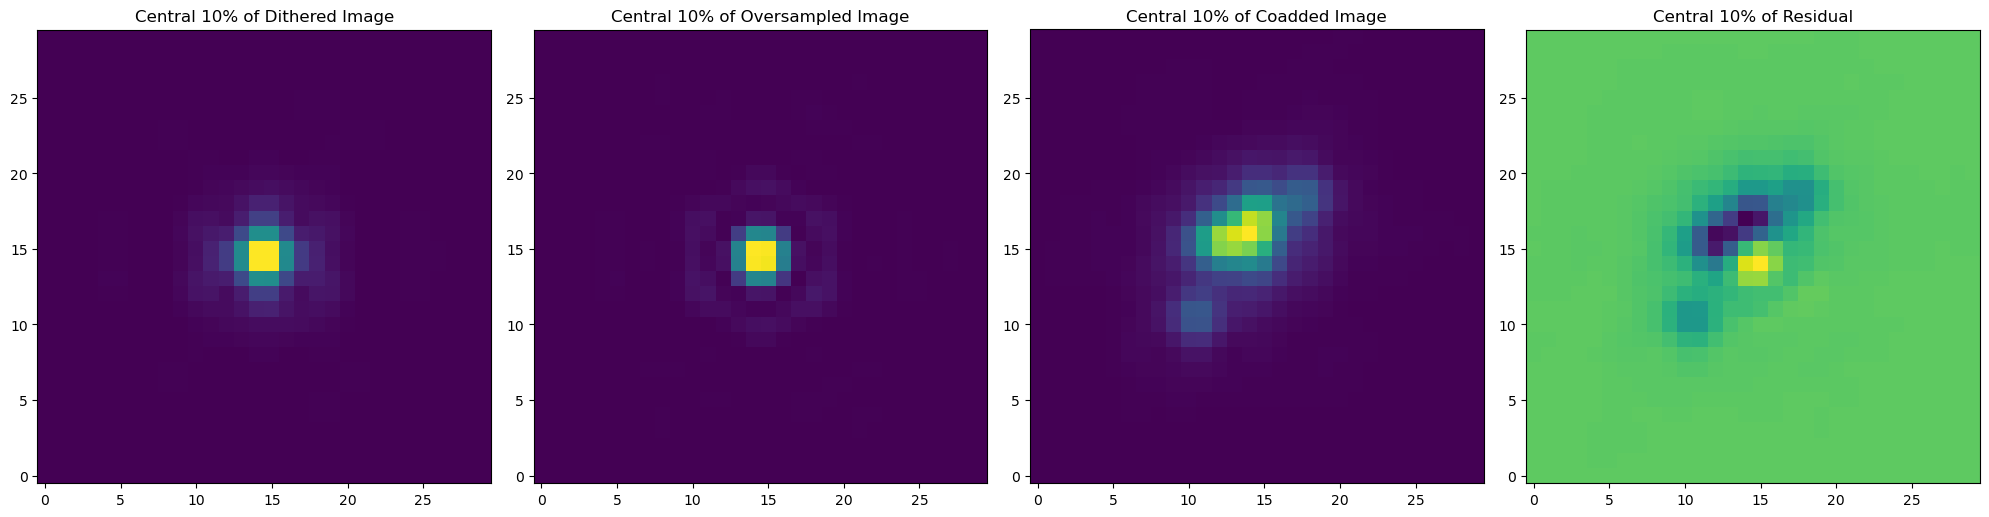

In [18]:
# Resize dithered images to match the oversampled image
resized_dither_images = [
    zoom(image, oversample_factor, order=1) for image in dither_images
]

# Create a blank array for coadding dithered images
coadded_image = np.zeros_like(oversampled_data)

# Drizzle: Align and combine the resized dithered images
for idx, (image, (dx, dy)) in enumerate(zip(resized_dither_images, dither_offsets)):
    # Shift dither images onto a common grid (simple coadd for demonstration)
    shifted_image = np.roll(np.roll(image, int(dx * 10), axis=1), int(dy * 10), axis=0)
    coadded_image += shifted_image

# Normalize the coadded image
coadded_image /= num_dithers

# Calculate the residual between the oversampled image and the coadded image
residual = oversampled_data - coadded_image

# Extract central regions
central_dither = extract_central_region(resized_dither_images[0])
central_oversampled = extract_central_region(oversampled_data)
central_coadded = extract_central_region(coadded_image)
central_residual = extract_central_region(residual)

# Simplified plotting of central regions
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

# Plot one dithered image (central region)
axs[0].imshow(central_dither, origin='lower', cmap='viridis')
axs[0].set_title('Central 10% of Dithered Image')

# Plot oversampled image (central region)
axs[1].imshow(central_oversampled, origin='lower', cmap='viridis')
axs[1].set_title('Central 10% of Oversampled Image')

# Plot coadded image (central region)
axs[2].imshow(central_coadded, origin='lower', cmap='viridis')
axs[2].set_title('Central 10% of Coadded Image')

# Plot residual (central region)
axs[3].imshow(central_residual, origin='lower', cmap='viridis')
axs[3].set_title('Central 10% of Residual')

plt.tight_layout()
plt.show()

## Coadd using the original code written in Python way

In [70]:
import os, sys

from importlib import reload

import numpy as np
import numpy.linalg as la
from numpy import fft

import matplotlib as mpl
import matplotlib.pyplot as plt

import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.table import Table
from astropy.visualization import AsinhStretch
from astropy.wcs import WCS
from astropy.nddata import Cutout2D
from astropy.visualization import astropy_mpl_style
from astropy.stats import sigma_clipped_stats
from astropy.nddata import NDData

from photutils.detection import DAOStarFinder
from photutils.psf import EPSFBuilder
from photutils.psf import extract_stars
from photutils.centroids import centroid_com

from scipy.ndimage import shift

stretch = AsinhStretch()

plt.style.use(astropy_mpl_style)
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['image.interpolation'] = 'nearest'

np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

%matplotlib inline
%config InlineBackend.figure_format='retina'

import testing functions from `../src/`

In [71]:
sys.path.append('..')

import dither.utils as dutils
import dither.wrapper as wrapper
import dither.updated as updated

### Prepare Data

#### Read cutout paths

Naming convention of single images:

```
           "xxx_path"          
|-----------------------------|
/path/to/the/file/filename.fits
|----------------|------------|
    "xxx_dir"      "xxx_name"  
                               
xxx_data = array([[...]])      
```


Naming convention of lists:
```
xxx_paths = [xxx_path, xxx_path, ...]
xxx_names = [xxx_name, xxx_name, ...]
xxx_atlas = [xxx_data, xxx_data, ...]
```

In [102]:
cutout_dir = '/quasar/yichenliu/cutout_f250m'
cutout_paths = []
cutout_names = os.listdir(cutout_dir)
for cutout_name in cutout_names: 
    cutout_path = os.path.join(cutout_dir, cutout_name)
    cutout_paths.append(cutout_path)
cutout_paths.sort()

cutout_paths

['/quasar/yichenliu/cutout_f250m/jw01764001001_02101_00001_nrcblong_cal_bsub_aligned_cutout.fits',
 '/quasar/yichenliu/cutout_f250m/jw01764001001_02101_00002_nrcblong_cal_bsub_aligned_cutout.fits',
 '/quasar/yichenliu/cutout_f250m/jw01764001001_02101_00003_nrcblong_cal_bsub_aligned_cutout.fits',
 '/quasar/yichenliu/cutout_f250m/jw01764001001_02101_00004_nrcblong_cal_bsub_aligned_cutout.fits',
 '/quasar/yichenliu/cutout_f250m/jw01764001001_02101_00005_nrcblong_cal_bsub_aligned_cutout.fits',
 '/quasar/yichenliu/cutout_f250m/jw01764001001_02101_00006_nrcblong_cal_bsub_aligned_cutout.fits',
 '/quasar/yichenliu/cutout_f250m/jw01764001001_02101_00007_nrcblong_cal_bsub_aligned_cutout.fits',
 '/quasar/yichenliu/cutout_f250m/jw01764001001_02101_00008_nrcblong_cal_bsub_aligned_cutout.fits',
 '/quasar/yichenliu/cutout_f250m/jw01764001001_02101_00009_nrcblong_cal_bsub_aligned_cutout.fits']

#### Load images

In [73]:
orig_atlas = []
for cutout_path in cutout_paths: 
    with fits.open(cutout_path) as hdul: 
        data = hdul[1].data
        orig_atlas.append(data)

#### Get the offsets

Find the brightest pixel near the center

In [74]:
brightest_xys = []
for data in orig_atlas: 
    xy = dutils.get_brightest_pixel(data, 50, 100, 50, 100) # some random limits
    brightest_xys.append(xy)
brightest_xys = np.array(brightest_xys)

brightest_xys

array([[76, 77],
       [80, 77],
       [78, 80],
       [77, 76],
       [77, 75],
       [77, 76],
       [77, 76],
       [76, 76],
       [77, 76]])

pad the images to align its centers

In [75]:
pad = dutils.calculate_padding_radius(brightest_xys)

aligned_atlas = []
for i in range(9):
    data = orig_atlas[i]
    brightest_xy = brightest_xys[i]
    aligned_data = dutils.pad_image_with_centroid(data, pad, brightest_xy)
    aligned_atlas.append(aligned_data)

Calculate the centroids by averaging up the pixels within the central area using `centroid_com` in `Photutils`

In [76]:
cx, cy = dutils.get_pixel_center_from_array(orig_atlas[0])
r = 5

centroids = []
for i in range(9): 
    data = aligned_atlas[i]
    centroid = dutils.get_centroids_using_centroid_com(data, cx, cy, r)
    centroids.append(centroid)
centroids = np.array(centroids)
centroids -= [cx, cy]
centroids

array([[-0.038, -0.44 ],
       [-0.408, -0.225],
       [ 0.189, -0.048],
       [-0.603, -0.125],
       [-0.091,  0.093],
       [-0.453,  0.342],
       [-0.303,  0.24 ],
       [ 0.091, -0.448],
       [-0.224, -0.289]])

A more proper way is to perform a source detection using `DAOStarFinder` in `Photusils`. These two methods have on average 6% difference. 

In [77]:
centroids = []

for i in range(9): 
    data = aligned_atlas[i]
    centroid = dutils.get_centroids_using_DAOStarFinder(data, cx, cy)
    centroids.append(centroid)
centroids = np.array(centroids)
centroids -= [cx, cy]

centroids

array([[ 0.096, -0.456],
       [-0.311, -0.152],
       [ 0.395,  0.036],
       [-0.559, -0.082],
       [ 0.077,  0.149],
       [-0.315,  0.445],
       [-0.2  ,  0.352],
       [ 0.254, -0.457],
       [-0.114, -0.237]])

Visually check the center

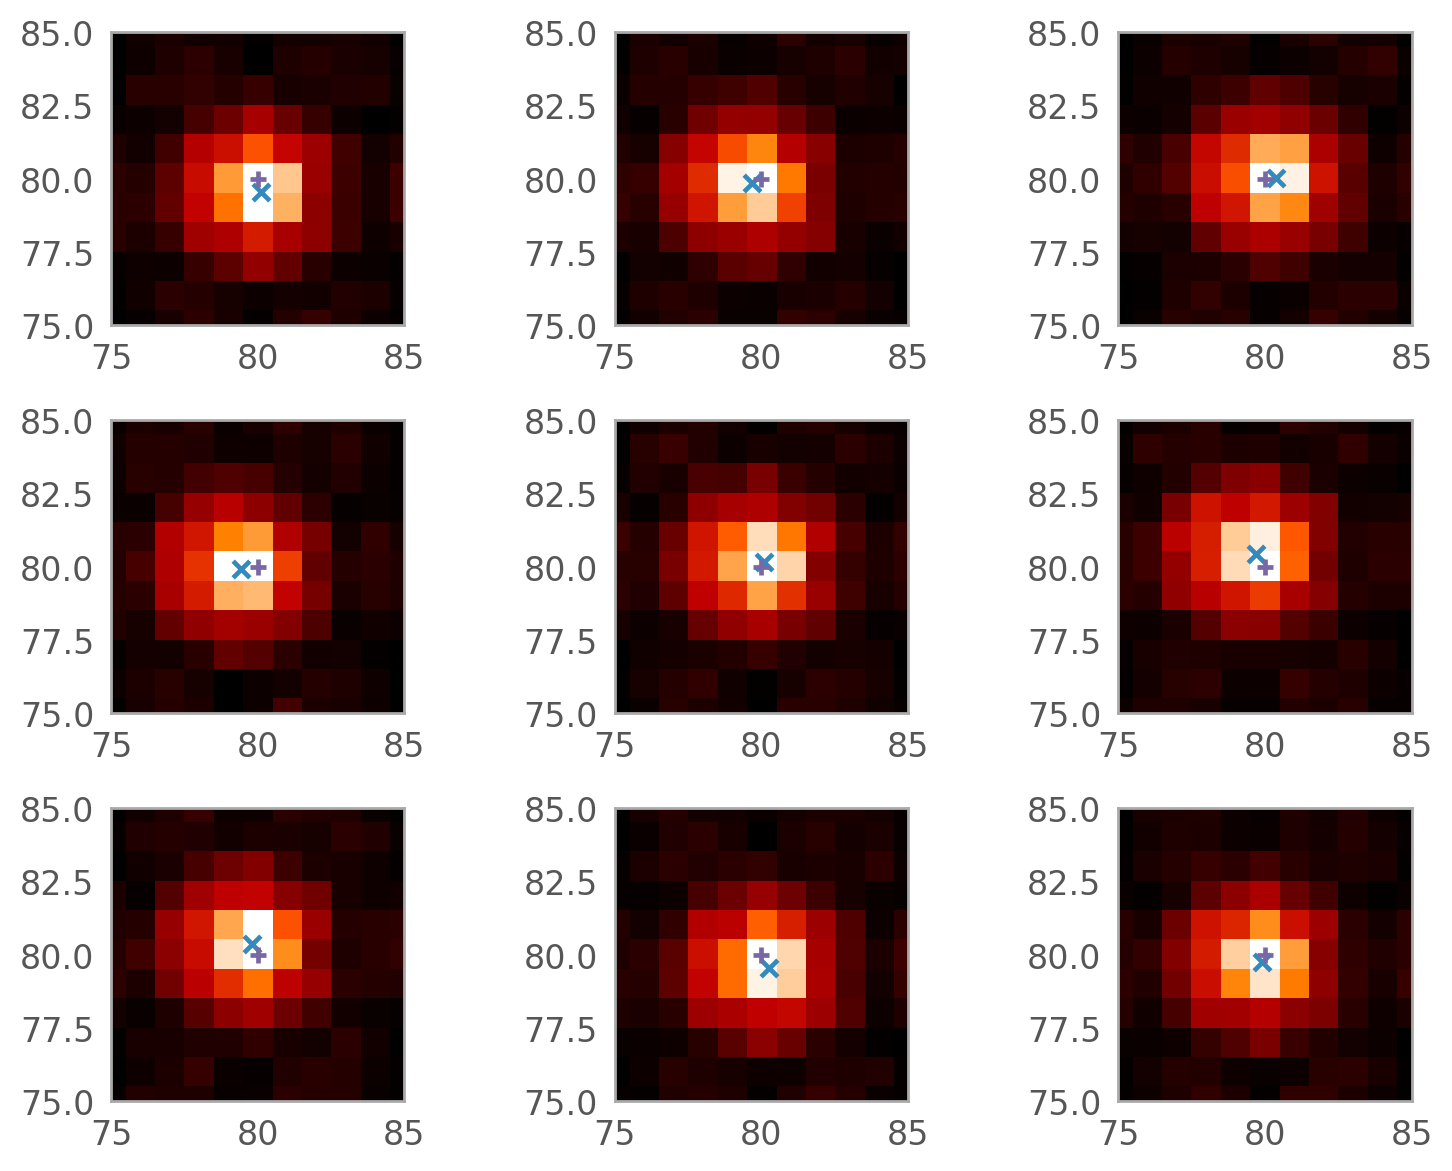

In [78]:
fig, axs = plt.subplots(3, 3)
axs = axs.flat
for i in range(9): 
    data = aligned_atlas[i]
    
    qso_center = [cx+centroids[i, 0], cx+centroids[i, 1]]
    img_center = [cx, cy]
    axs[i].imshow(np.arcsinh(data), vmin=0, vmax=5)
    axs[i].scatter(*qso_center, marker='x')
    axs[i].scatter(*img_center, marker='+')
    axs[i].set_xlim(cx-5, cx+5)
    axs[i].set_ylim(cy-5, cy+5)
    axs[i].grid(False)
plt.tight_layout()
plt.show()

#### Mask out cosmic rays

The AGN is excluded by counting the number of connected pixels

In [79]:
masks = []

for i in range(9):
    data = aligned_atlas[i]
    mask = dutils.get_cosmic_ray_mask_without_AGN(data, kernel_size=3, sigma_threshold=40, max_connected_pixels=16)
    masks.append(mask)

Mask them out by setting them to 0 because the image is already background subtracted

In [80]:
aligned_atlas_masked = []
for i in range(9): 
    data_masked = aligned_atlas[i].copy()
    mask = masks[i]
    data_masked[mask] = 0
    aligned_atlas_masked.append(data_masked)

Visually check the mask

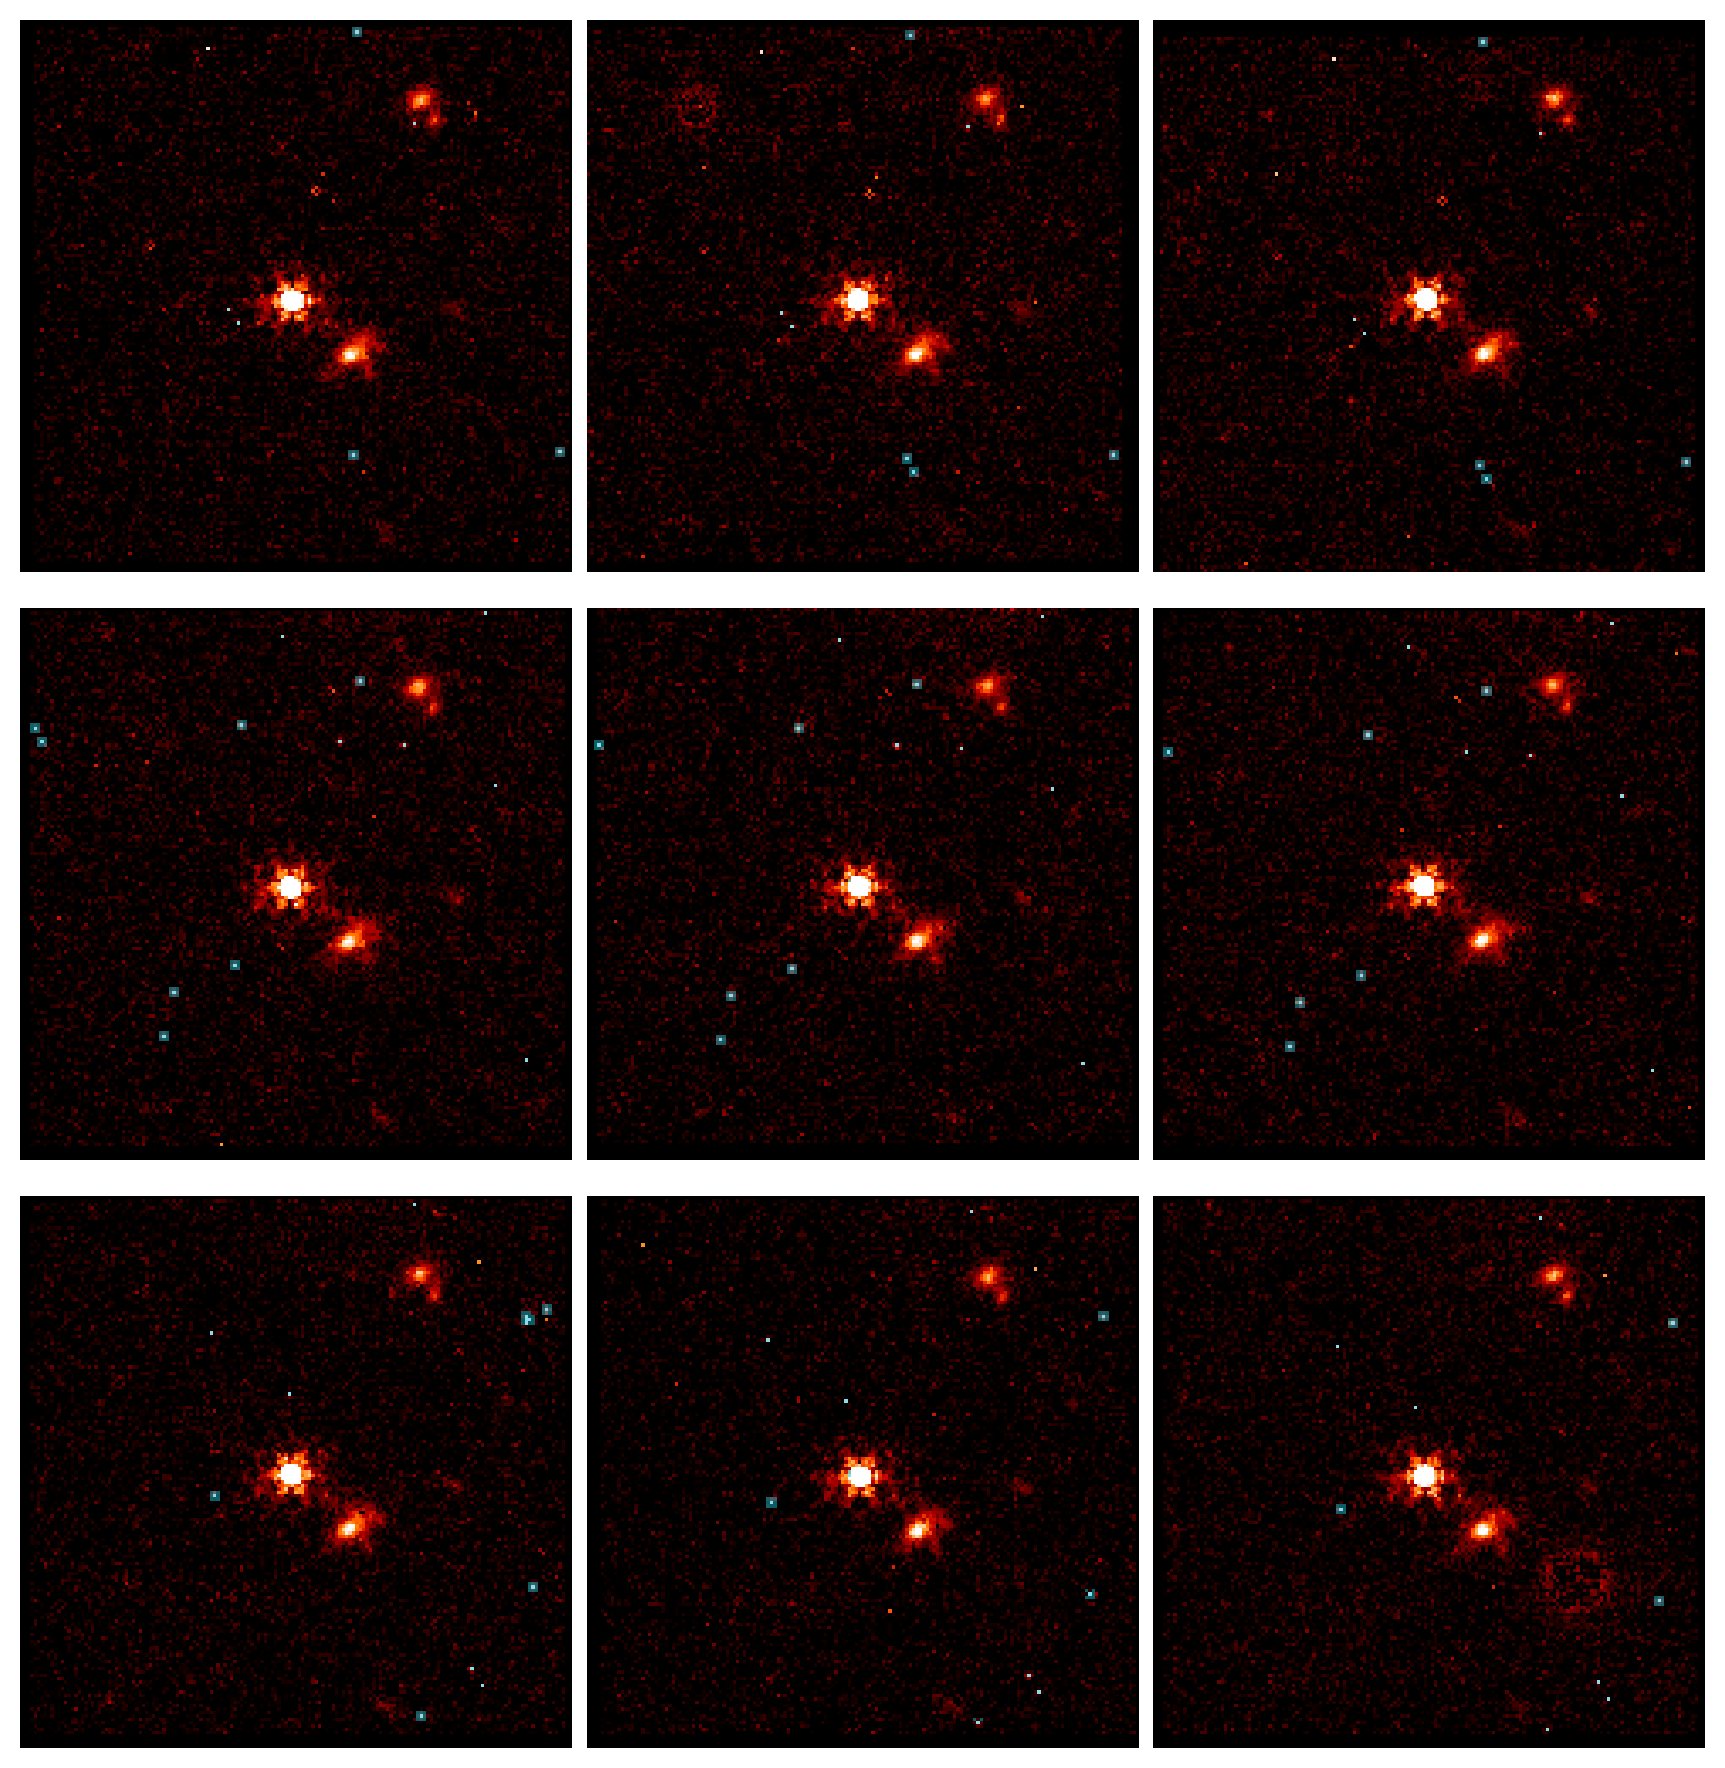

In [81]:
fig, axs = plt.subplots(3, 3, figsize=(9, 9))
axs = axs.flat
for i in range(9): 
    data = aligned_atlas[i]
    mask = masks[i]
    axs[i].imshow(stretch(data), vmin=0, vmax=1)
    axs[i].imshow(mask, cmap=plt.get_cmap('tab10'), alpha=mask*0.5)
    axs[i].grid(False)
    axs[i].axis('off')
plt.tight_layout()
plt.show()

### Coadd Images Using Updated Code

[[-0.456  0.096  1.   ]
 [-0.152 -0.311  1.   ]
 [ 0.036  0.395  1.   ]
 [-0.082 -0.559  1.   ]
 [ 0.149  0.077  1.   ]
 [ 0.445 -0.315  1.   ]
 [ 0.352 -0.2    1.   ]
 [-0.457  0.254  1.   ]
 [-0.237 -0.114  1.   ]]


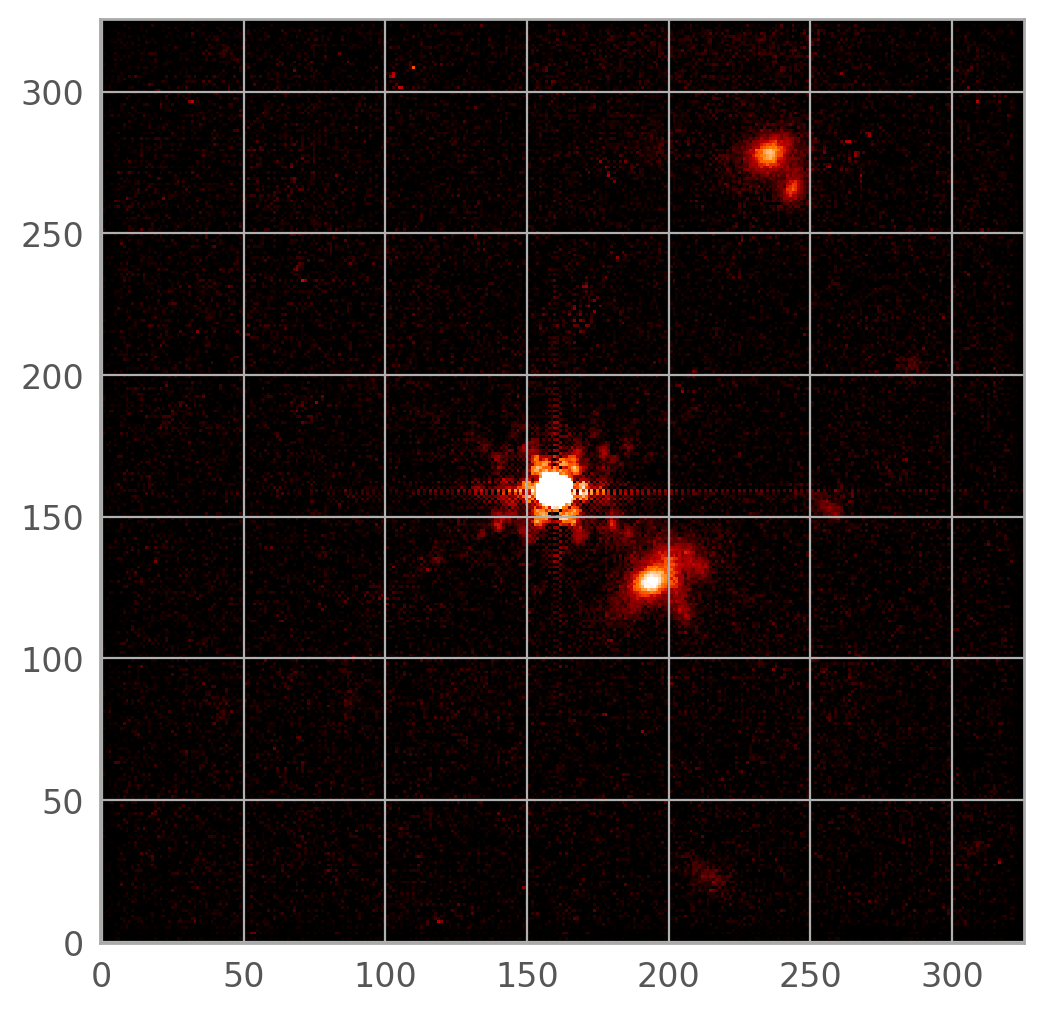

In [82]:
from dither.wrapper import NR_FREQ, NC_FREQ
NSUB = 2


used_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8]

# [y, x, wt]
offsets = np.hstack((centroids[used_indices, 1:2], 
                     centroids[used_indices, 0:1], 
                     [[1]]*len(used_indices)))
# offsets[0, 0] = 0
# offsets[0, 1] = 0
print(offsets)

Atotal = np.zeros((NC_FREQ, NR_FREQ))
for i, j in enumerate(used_indices): 
    data = aligned_atlas_masked[j]
    nx, ny = data.shape
    data_large = np.zeros((NC_FREQ, NR_FREQ))
    data_large[:nx*NSUB:NSUB, :ny*NSUB:NSUB] = data
    A = updated.real2dfft_forward(data_large)
    n = i + 1
    Aphased = updated.phase_shift(A, offsets, n, verbose=False)
    Atotal += Aphased

f = updated.real2dfft_backward(Atotal)

nx, ny = aligned_atlas[0].shape
nx_large = nx*NSUB
ny_large = ny*NSUB
plt.imshow(stretch(f[:nx_large, :ny_large]))
plt.show()

### TESTING CODE

In [47]:
# sys.path.append('/quasar/yichenliu/astro-utils')

# from autils import interactive_plot

Output()

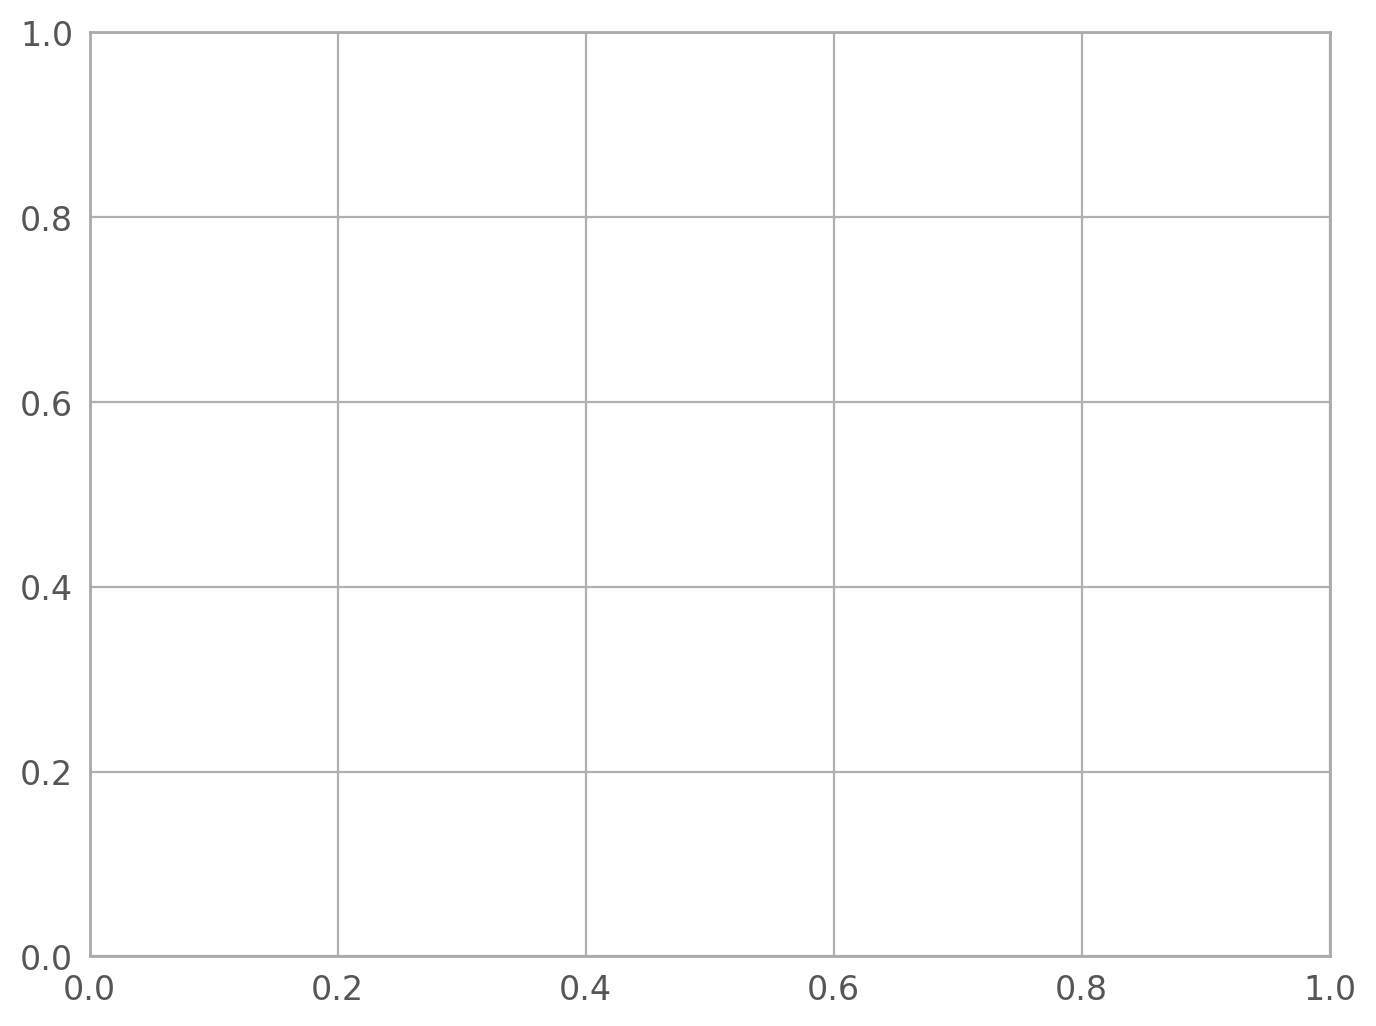

In [48]:
interactive_plot(f[:nx_large, :ny_large])

Show the transformed image and the power spectrum

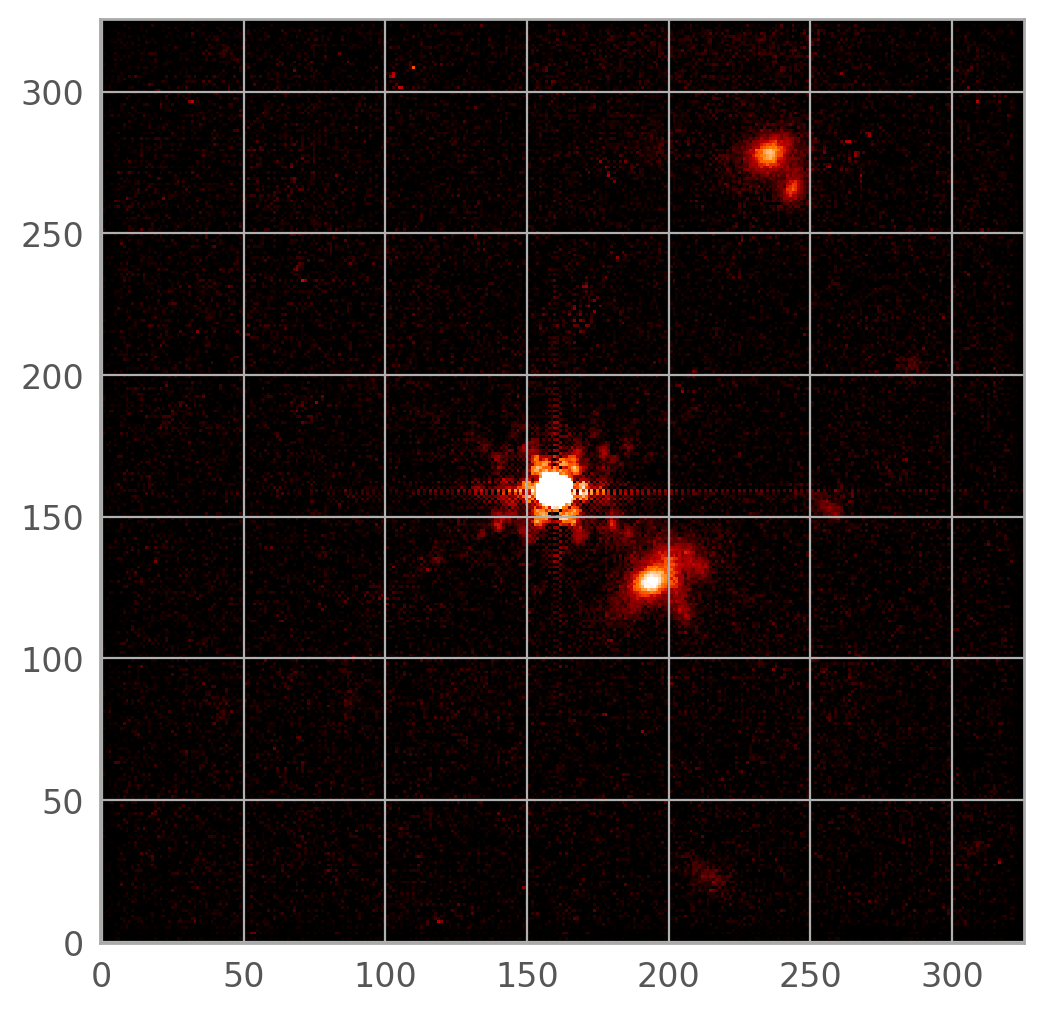

In [83]:
nx, ny = aligned_atlas[0].shape
nx_large = nx*NSUB
ny_large = ny*NSUB

plt.imshow(stretch(f[:nx_large, :ny_large]))

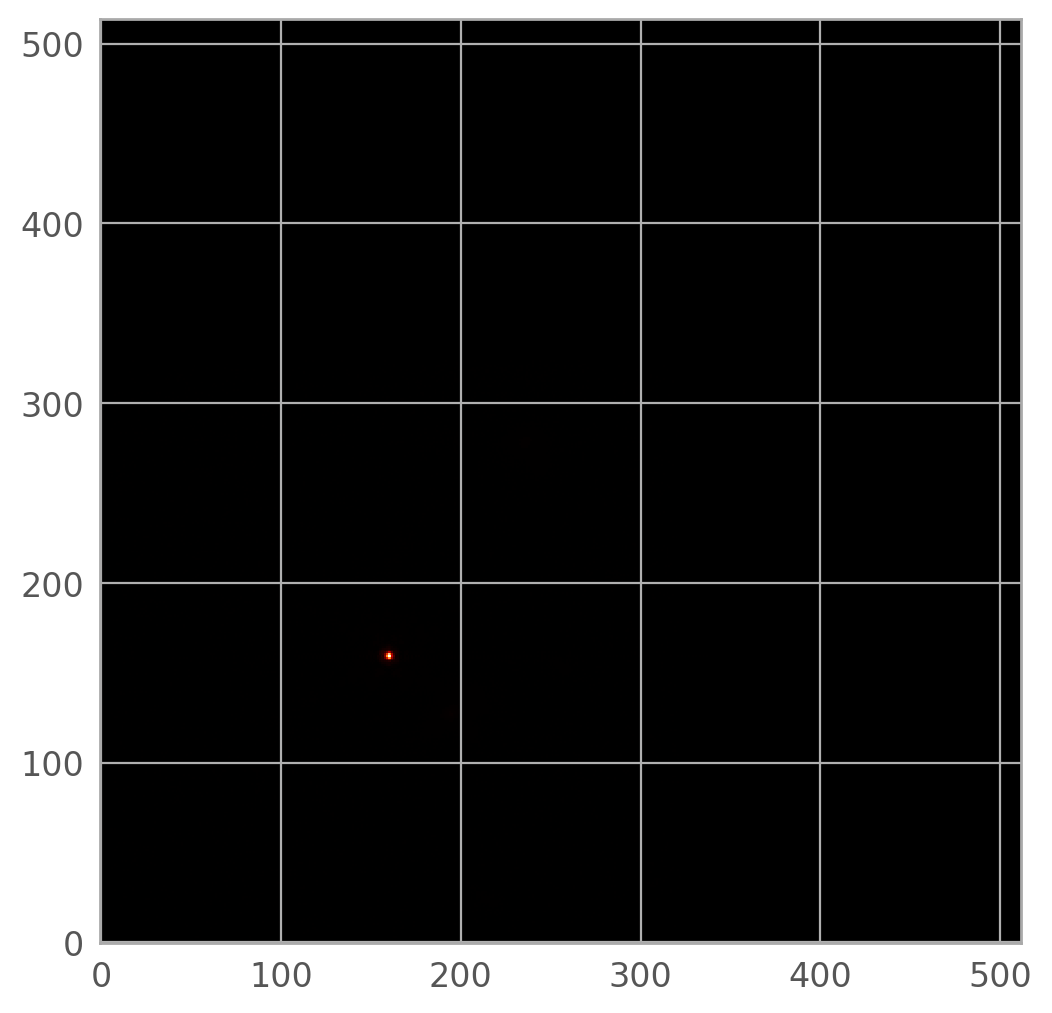

In [84]:
plt.imshow(f)

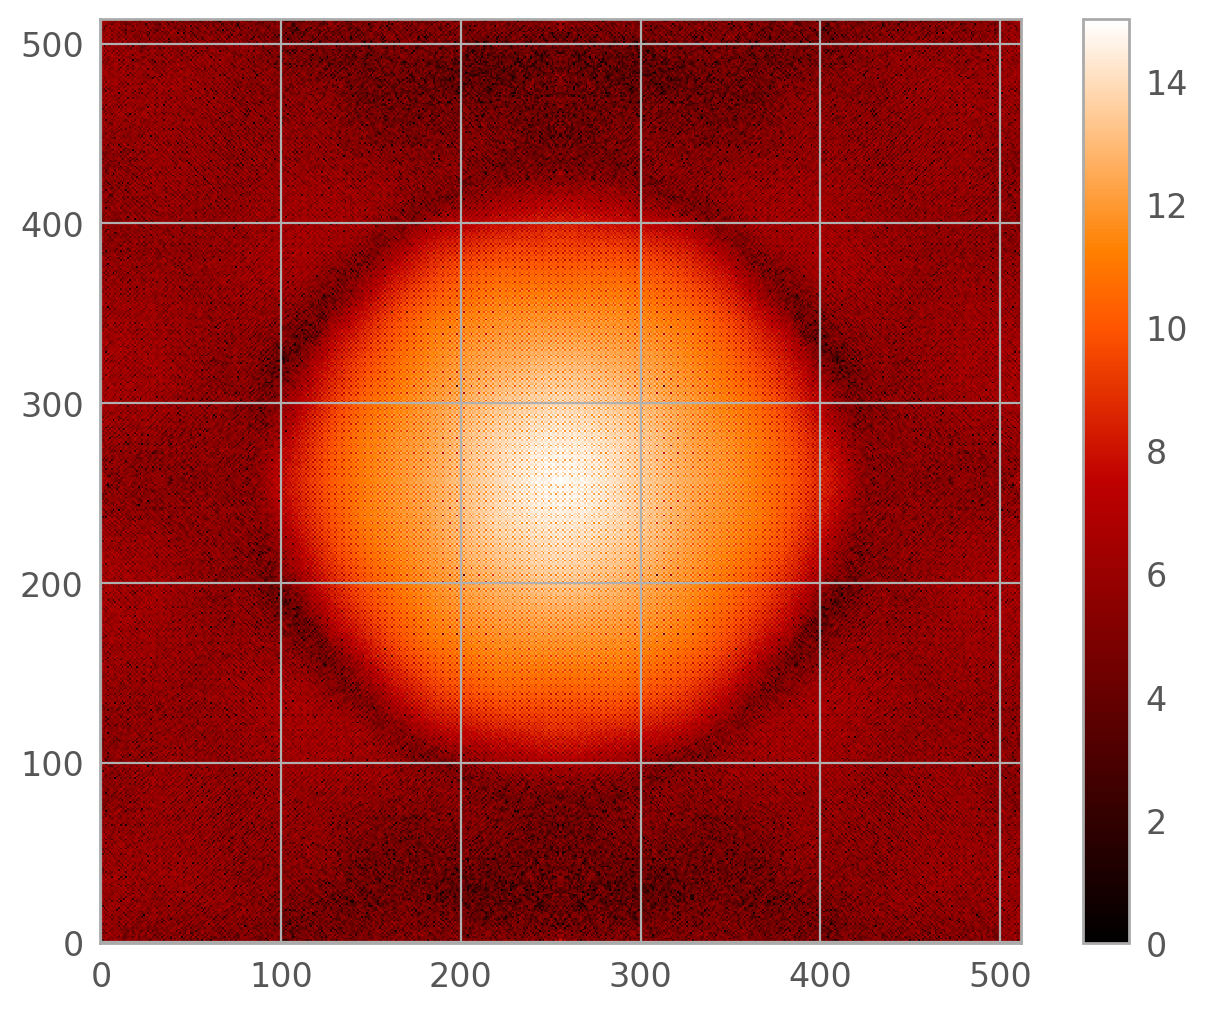

In [90]:
# pow = dutils.get_power_spectrum_from_realfft2d(Atotal)
pow = dutils.get_power_spectrum_from_realfft2d(updated.real2dfft_forward(f))
plt.imshow(np.log(pow+1), vmin=0, vmax=15)
plt.colorbar()
plt.show()

In [51]:
# TODO: apply wiener filter to eliminate spikes

  ERROR: File /quasar/yichenliu/cutout_unfold_JWST/jw01764-o001_20230518t010000_clear-f250m_i2d_bsub_gaia_cutout.fits already exists. If you mean to replace it then use the argument "overwrite=True".


Set OBSGEO-B to   -21.931130 from OBSGEO-[XYZ].
Set OBSGEO-H to 1540023708.650 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


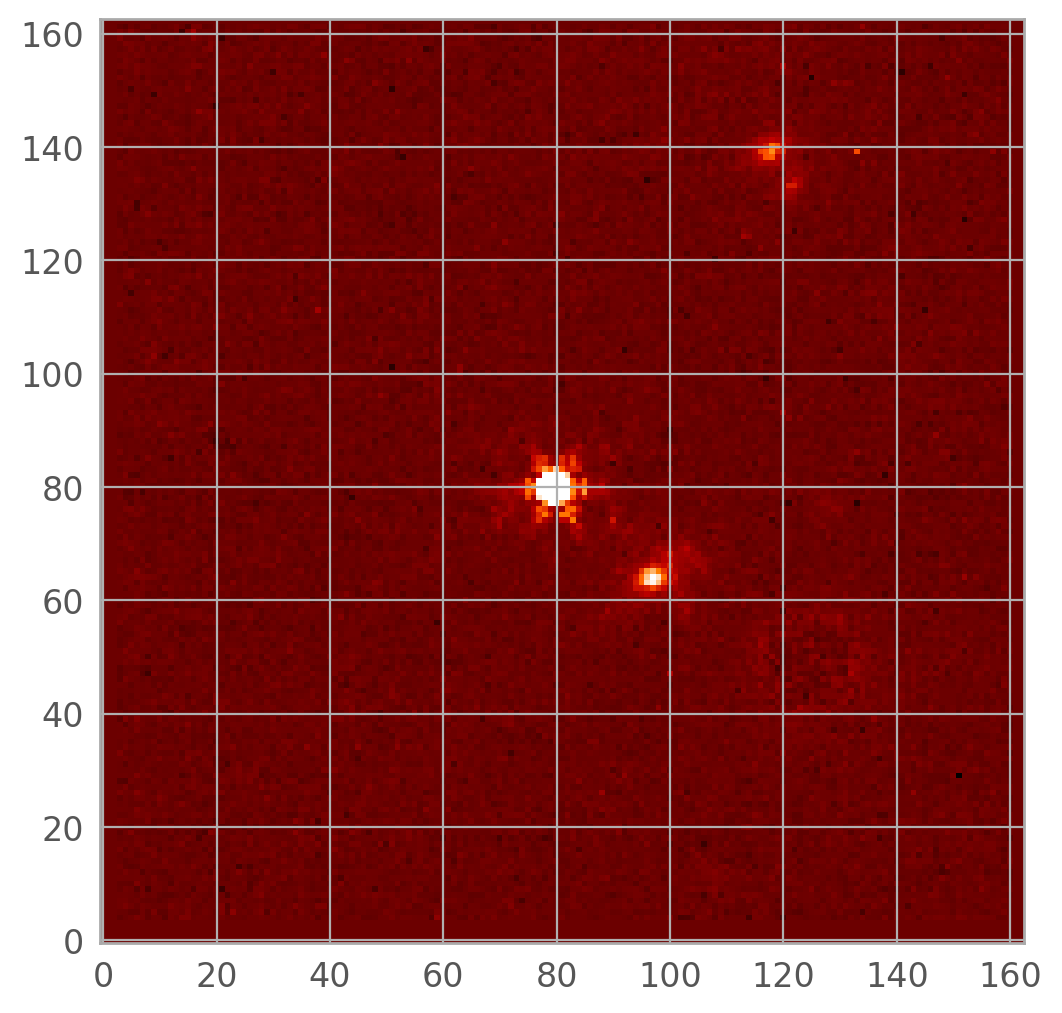

In [52]:
agn_coord = SkyCoord("J100758.26+211529.2", unit=(u.hourangle, u.deg), frame='icrs')
jwstpath = '/quasar/data/GO1764/NIRCam/redux_v01/jw01764-o001_20230518t010000_clear-f250m_i2d_bsub_gaia.fits'
radius = 5 # arcsec
cutout_dir = '/quasar/yichenliu/cutout_unfold_JWST'
cutout_paths = []
fits_path = jwstpath
directory = os.path.dirname(fits_path)
filename = os.path.basename(fits_path)
cutout_path = os.path.join(cutout_dir, filename[:-5]+'_cutout.fits')
try: 
    dutils.create_cutout_fits(fits_path, cutout_path, agn_coord, radius)
except OSError as E: 
    print(f'  ERROR: {E}')
cutout_paths.append(cutout_path)
# break
plt.imshow(np.arcsinh(data), vmax=1)

Filename: /quasar/yichenliu/cutout_unfold_JWST/jw01764-o001_20230518t010000_clear-f250m_i2d_bsub_gaia_cutout.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     373   ()      
  1  SCI           1 ImageHDU        81   (316, 316)   float64   
  2  ERR           1 ImageHDU        41   (316, 316)   float32   
  3  VAR_POISSON    1 ImageHDU        40   (316, 316)   float32   
  4  VAR_RNOISE    1 ImageHDU        40   (316, 316)   float32   
  5  VAR_FLAT      1 ImageHDU        40   (316, 316)   float32   
None


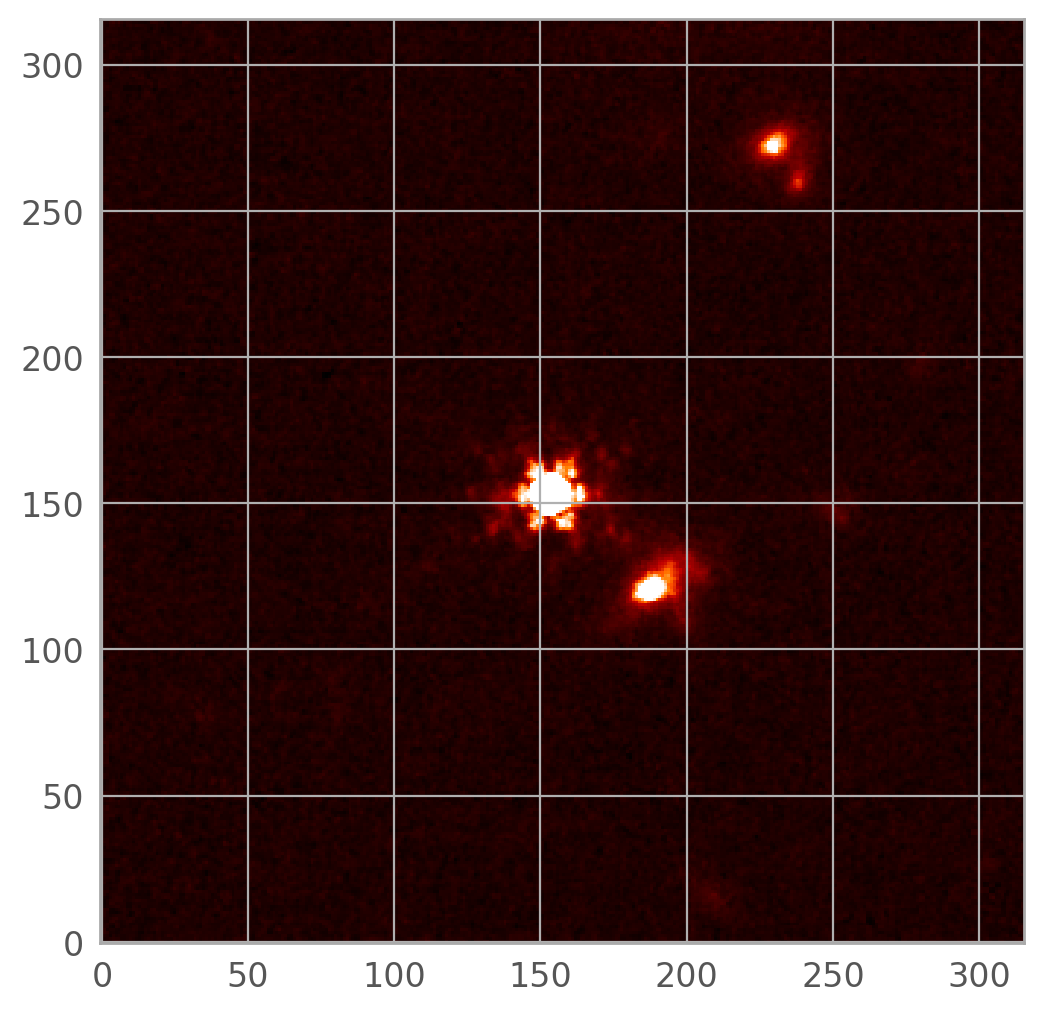

In [53]:
jwstpath = '/quasar/data/GO1764/NIRCam/redux_v01/jw01764-o001_20230518t010000_clear-f250m_i2d_bsub_gaia.fits'
cutpath = '/quasar/yichenliu/cutout_unfold_JWST/jw01764-o001_20230518t010000_clear-f250m_i2d_bsub_gaia_cutout.fits'

with fits.open(cutpath) as hdu:
    print(hdu.info())
    cutdata = hdu['SCI'].data

plt.imshow(cutdata, vmax=0.5)

In [96]:
cutdata.shape

(316, 316)

In [98]:
NC_FREQ

514

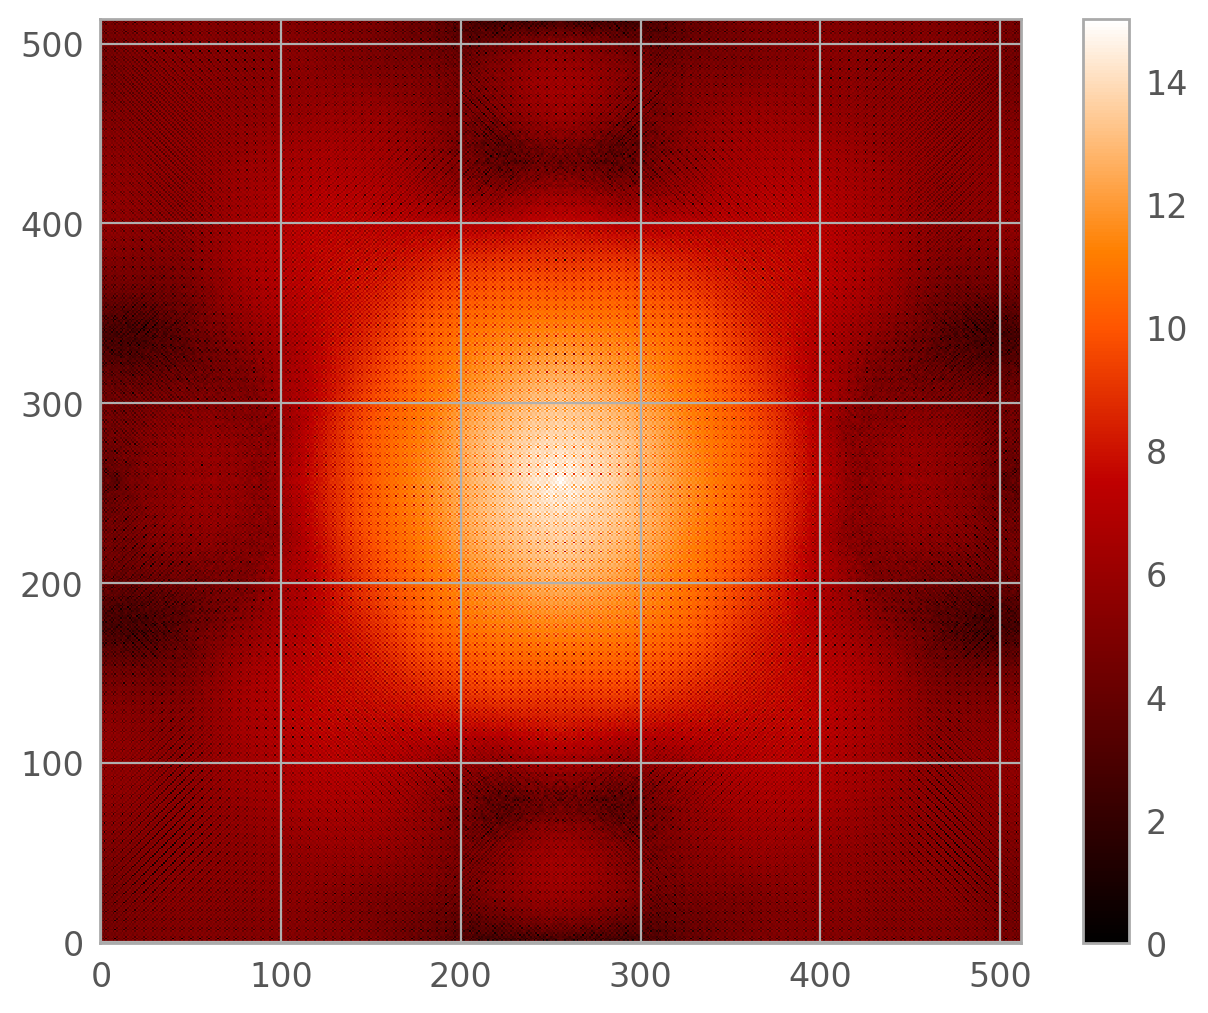

In [100]:
nx, ny = cutdata.shape
data_large[:nx, :ny] = cutdata

pow = dutils.get_power_spectrum_from_realfft2d(updated.real2dfft_forward(data_large))
plt.imshow(np.log(pow+1), vmin=0, vmax=15)
plt.colorbar()
plt.show()

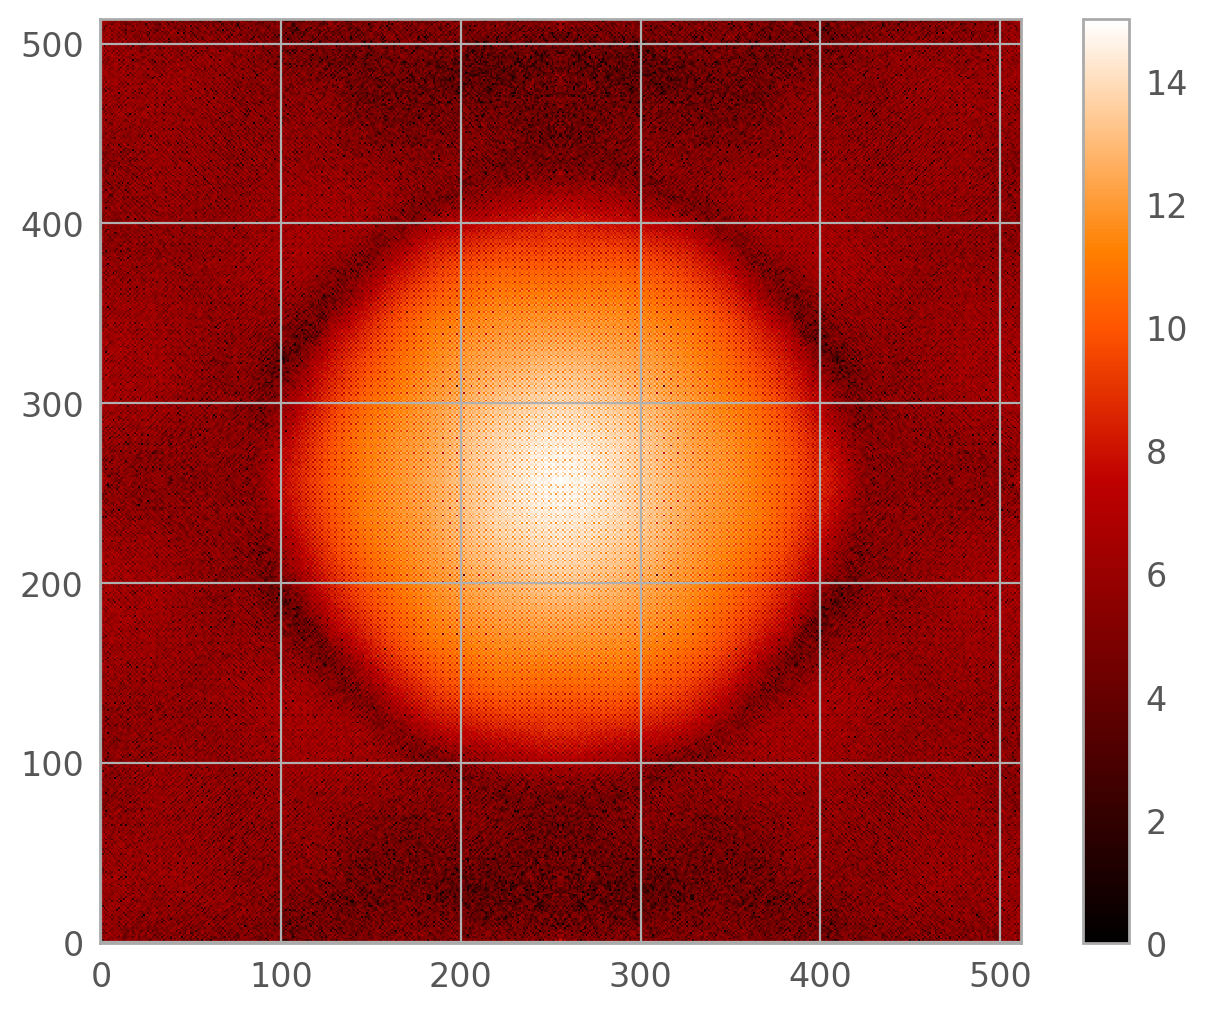

In [91]:
# pow = dutils.get_power_spectrum_from_realfft2d(Atotal)
pow = dutils.get_power_spectrum_from_realfft2d(updated.real2dfft_forward(f)) 
plt.imshow(np.log(pow+1), vmin=0, vmax=15)
plt.colorbar()
plt.show()

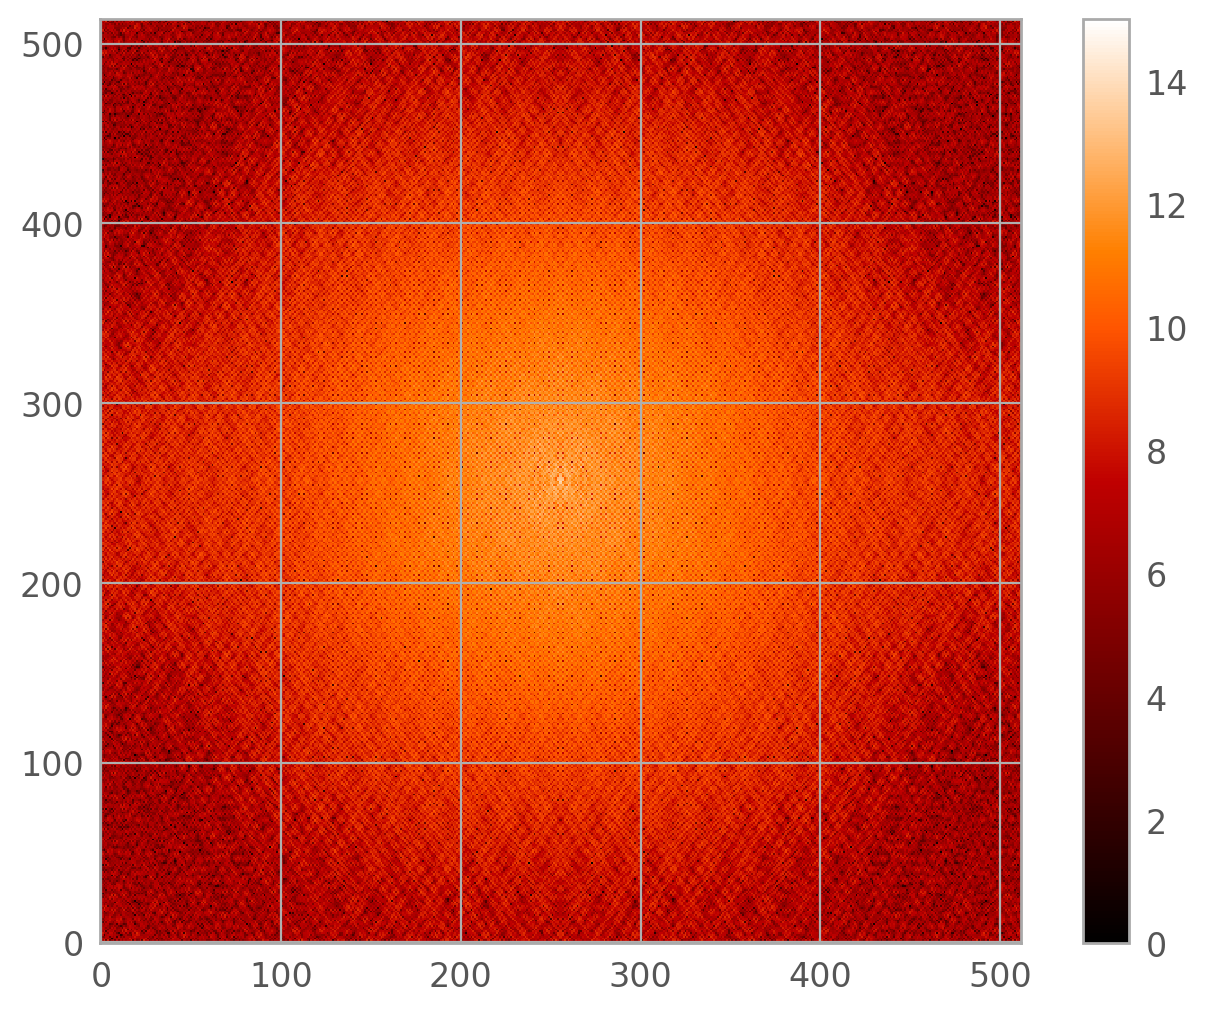

In [105]:
nx, ny = aligned_atlas[i].shape
data_large[:nx, :ny] = aligned_atlas[i]

pow = dutils.get_power_spectrum_from_realfft2d(updated.real2dfft_forward(data_large)) 
plt.imshow(np.log(pow+1), vmin=0, vmax=15)
plt.colorbar()
plt.show()

In [55]:
import numpy as np
from scipy.ndimage import gaussian_filter, convolve

# Step 1: Generate a Gaussian array
def generate_gaussian_array(size, mean, std_dev):
    x = np.linspace(-size // 2, size // 2, size)
    y = np.linspace(-size // 2, size // 2, size)
    x, y = np.meshgrid(x, y)
    gaussian_array = (1 / (2 * np.pi * std_dev**2)) * np.exp(-((x - mean)**2 + (y - mean)**2) / (2 * std_dev**2))
    return gaussian_array


def convolve_with_stride(data, kernel, stride, xoffset, yoffset):
    # Convolve the data with the kernel
    convolved = convolve(data, kernel, mode='constant', cval=0.0)
    
    # Downsample the result using the specified stride
    return convolved[xoffset::stride, yoffset::stride]



In [56]:
size = 1200
mean = 0          
std_dev = 6

gaussian_array = generate_gaussian_array(size, mean, std_dev)

kernel_size = 12
kernel = np.ones((kernel_size, kernel_size))

stride = 12 

images = []
offsets_gauss = []
for i in range(3):
    for j in range(3):
        xoffset = i*4
        yoffset = j*4
        convolved_array = convolve_with_stride(gaussian_array, kernel, stride, xoffset, yoffset)
        images.append(convolved_array)
        offsets_gauss.append([-j/3, -i/3])
offsets_gauss = np.array(offsets_gauss)

# Output the shapes of the arrays
print("Original Gaussian array shape:", gaussian_array.shape)
print("Convolved array shape:", convolved_array.shape)
offsets_gauss

Original Gaussian array shape: (1200, 1200)
Convolved array shape: (100, 100)


array([[ 0.   ,  0.   ],
       [-0.333,  0.   ],
       [-0.667,  0.   ],
       [ 0.   , -0.333],
       [-0.333, -0.333],
       [-0.667, -0.333],
       [ 0.   , -0.667],
       [-0.333, -0.667],
       [-0.667, -0.667]])

[[ 0.     0.     1.   ]
 [ 0.    -0.333  1.   ]
 [ 0.    -0.667  1.   ]
 [-0.333  0.     1.   ]
 [-0.333 -0.333  1.   ]
 [-0.333 -0.667  1.   ]
 [-0.667  0.     1.   ]
 [-0.667 -0.333  1.   ]
 [-0.667 -0.667  1.   ]]


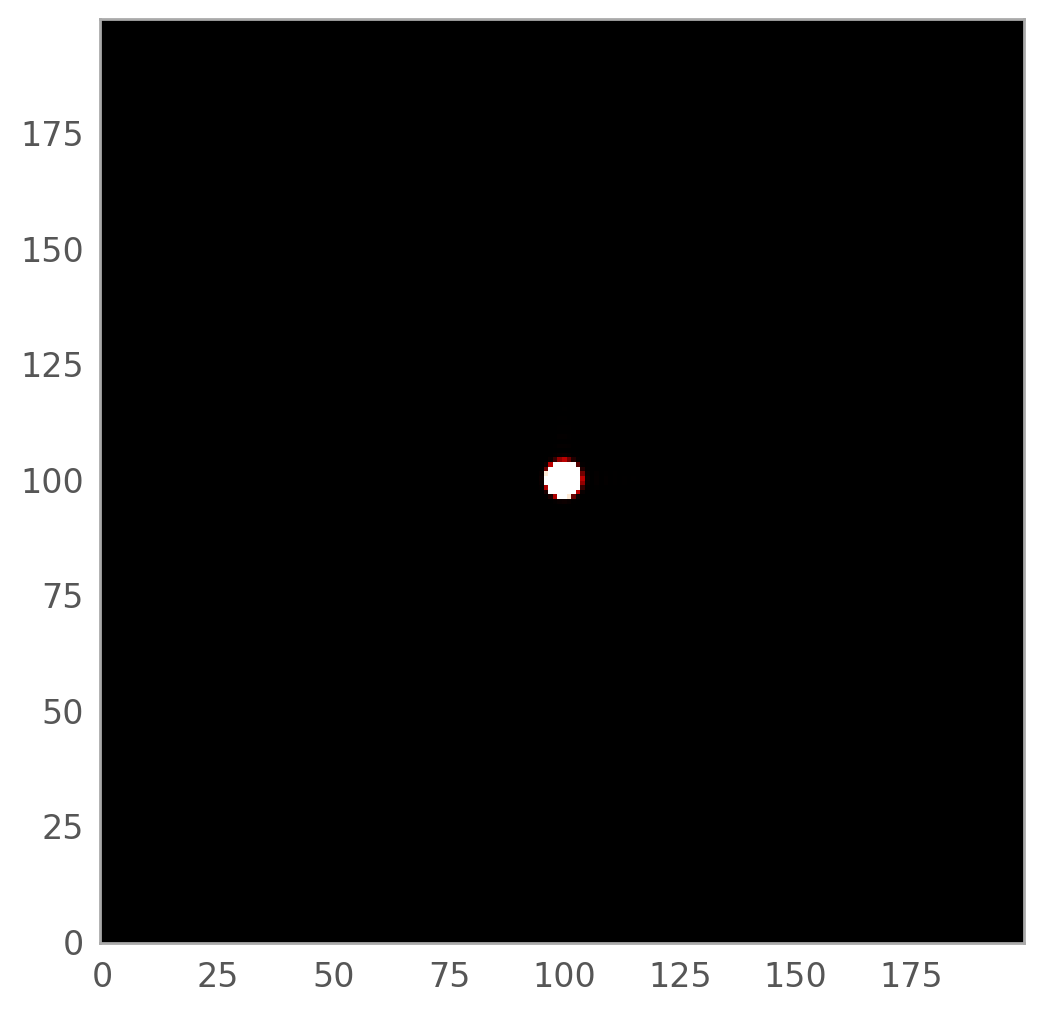

In [57]:
from dither.wrapper import NR_FREQ, NC_FREQ
NSUB = 2


used_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8]

# [y, x, wt]
offsets = np.hstack((offsets_gauss[used_indices, 1:2], 
                     offsets_gauss[used_indices, 0:1], 
                     [[1]]*len(used_indices)))
offsets[1, 1]+=0
print(offsets)

Atotal = np.zeros((NC_FREQ, NR_FREQ))
for i, j in enumerate(used_indices): 
    data = images[j]
    nx, ny = data.shape
    data_large = np.zeros((NC_FREQ, NR_FREQ))
    data_large[:nx*NSUB:NSUB, :ny*NSUB:NSUB] = data
    A = updated.real2dfft_forward(data_large)
    n = i + 1
    Aphased = updated.phase_shift(A, offsets, n, verbose=False)
    Atotal += Aphased

f = updated.real2dfft_backward(Atotal)

nx, ny = images[0].shape
nx_large = nx*NSUB
ny_large = ny*NSUB
plt.imshow(f[:nx_large, :ny_large], vmin=0, vmax=0.001)
plt.grid(False)
plt.show()

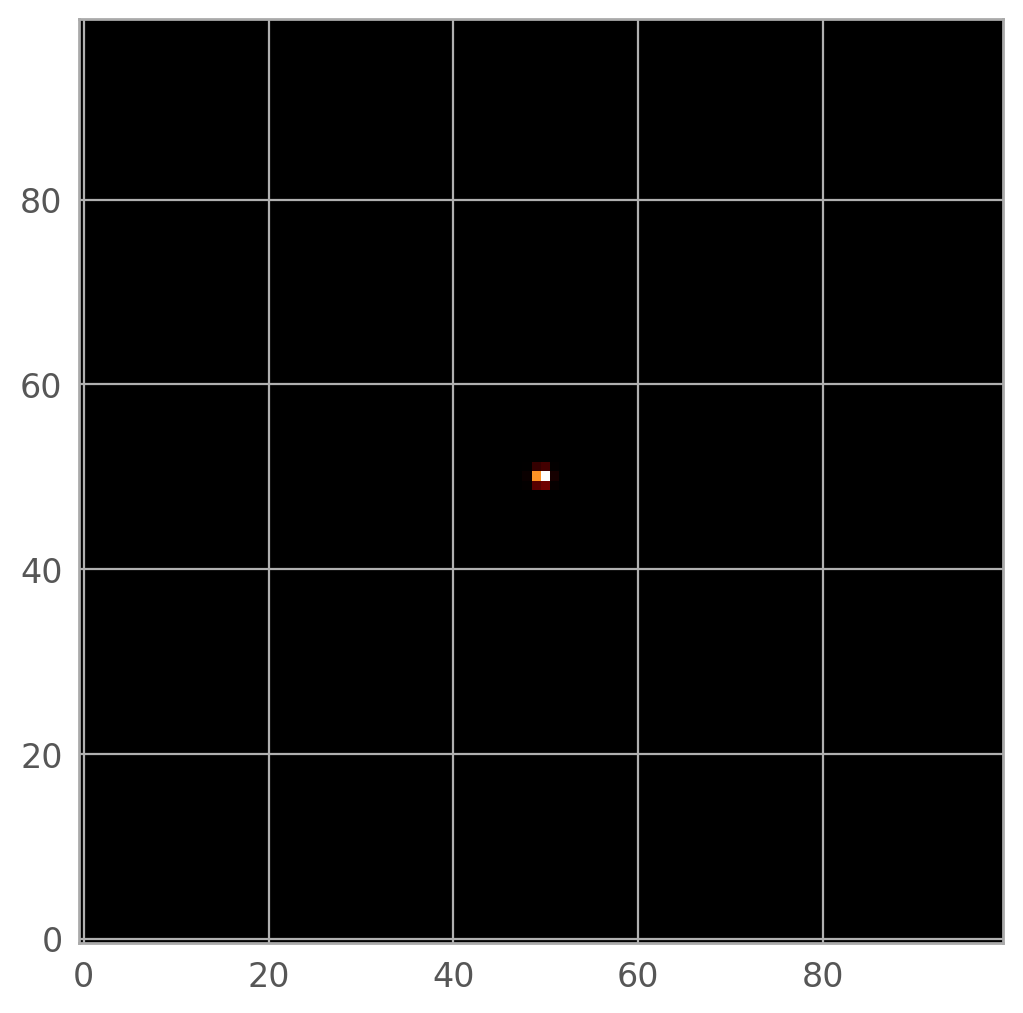

In [58]:
plt.imshow(images[1])